# **Human Gait Analysis using Skeleton and Pressure Data**

## **Setup**

We import core libraries for file I/O, tabular manipulation, and basic visualization.

In [99]:
# Packages

from google.colab import drive
import zipfile
import os
import re
import copy
from datetime import datetime
from typing import List, Dict, Tuple

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from scipy import stats
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks,regularizers, Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

import time
import psutil
import gc

In [6]:
CONFIG = {
    'TEST_SIZE': 0.15,
    'VAL_SIZE': 0.15,
    'RANDOM_STATE': 42,
    'PERC_MAX_TIMESTEPS': 0.25,
    'MAX_TIMESTEPS': 100,
    'TRUNCATING': 'pre',
    'PADDING': 'post',
    'PAD_VALUE': 0.0,
    'NUM_FEATURES_TRIMMED': 75,
    'JOINTS_ANGLES': True,
    'VELOCITIES' : True,
    'LATENT_DIM': 512,
    'BATCH_SIZE': 32,
    'EPOCHS': 100,
    'PATIENCE': 10,
    'K_FOLDS': 5
}

def set_seed(seed=42):
    """
    Sets the random seed for Python, NumPy, and TensorFlow for
    reproducible results. It also configures TensorFlow to use
    deterministic operations on the GPU.
    """
    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # TensorFlow
    tf.random.set_seed(seed)

    # Configure TensorFlow for determinism
    tf.config.experimental.enable_op_determinism()

    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CONFIG['RANDOM_STATE'])
print("Seeds set and TensorFlow determinism enabled.")

Seeds set and TensorFlow determinism enabled.


## **Data Loading**

We mount Google Drive and extract the project archive into `/content/`.

In [7]:
# Data Loading

drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/ColabNotebooks/humanData/HDA_proj_A2.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("✅ Data extracted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data extracted


### **Create Manifest**

We build a manifest DataFrame listing every trial with paths to `skeleton.csv` and `pressure.csv`, plus metadata (`subject_id`, `gait_type`, `trial_id`). This makes downstream loading reproducible and auditable.

In [8]:
# Create Manifest

def create_manifest(data_dir='/content/'):

  """
  Scan the extracted directory for subject folders and build a manifest
  of (subject, gait_type, trial, skeleton_path, pressure_path).
  Skips entries where required files are missing.
  """

  manifest = []
  subject_dirs = sorted([d for d in os.listdir(data_dir)
                        if d.startswith('subject') and os.path.isdir(os.path.join(data_dir, d))])

  for subject_name in subject_dirs:
      subject_id = int(subject_name.replace('subject', ''))
      subject_path = os.path.join(data_dir, subject_name)

      for gait_type in sorted(os.listdir(subject_path)):
          gait_path = os.path.join(subject_path, gait_type)

          for trial_name in sorted(os.listdir(gait_path)):
              trial_id = int(trial_name.replace('trial', ''))
              trial_path = os.path.join(gait_path, trial_name)

              manifest.append({
                  'subject_id': subject_id,
                  'gait_type': gait_type,
                  'trial_id': trial_id,
                  'skeleton_path': os.path.join(trial_path, 'skeleton.csv'),
                  'pressure_path': os.path.join(trial_path, 'pressure.csv')
              })

  return pd.DataFrame(manifest)

df_manifest = create_manifest()
print(f"Found {len(df_manifest)} trials, {df_manifest['gait_type'].nunique()} gait types")
display(df_manifest.head())

Found 1440 trials, 6 gait types


subject_id gait_type  trial_id  \
0           1  antalgic         1   
1           1  antalgic        10   
2           1  antalgic        11   
3           1  antalgic        12   
4           1  antalgic        13   

                                     skeleton_path  \
0   /content/subject1/antalgic/trial1/skeleton.csv   
1  /content/subject1/antalgic/trial10/skeleton.csv   
2  /content/subject1/antalgic/trial11/skeleton.csv   
3  /content/subject1/antalgic/trial12/skeleton.csv   
4  /content/subject1/antalgic/trial13/skeleton.csv   

                                     pressure_path  
0   /content/subject1/antalgic/trial1/pressure.csv  
1  /content/subject1/antalgic/trial10/pressure.csv  
2  /content/subject1/antalgic/trial11/pressure.csv  
3  /content/subject1/antalgic/trial12/pressure.csv  
4  /content/subject1/antalgic/trial13/pressure.csv

### **Load All Data**

We load every skeleton/pressure file listed in the manifest, record NaN/Inf counts, and keep labels for later modeling.

In [10]:
def load_trial_files(row: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, str, Dict[str, int]]:
    """
    Load one trial's skeleton and pressure CSVs.
    - Skeleton: index=first column (timestamp-like), drop 97th (all-NaN) column (32joints x 3axes = 96features).
    - Pressure: raw load.
    Returns (df_skel, df_press, label, quality_metrics)
    """
    # Skeleton
    df_skel = pd.read_csv(row['skeleton_path'], header=None)
    # First column is timestamp-like index
    df_skel.set_index(0, inplace=True)

    # Drop last column - entirely NaN
    df_skel = df_skel.drop(columns=[df_skel.columns[-1]])

    # Pressure
    df_press = pd.read_csv(row['pressure_path'], header=None)

    # Quality metrics
    q = {
        'n_nan_skel': int(df_skel.isna().sum().sum()),
        'n_inf_skel': int(np.isinf(df_skel.values).sum()),
        'n_nan_press': int(df_press.isna().sum().sum()),
        'n_inf_press': int(np.isinf(df_press.values).sum())
    }

    label = row['gait_type']
    return df_skel, df_press, label, q


skeleton_data: List[pd.DataFrame] = []
pressure_data: List[pd.DataFrame] = []
labels: List[str] = []

n_nan_skel, n_inf_skel, n_nan_press, n_inf_press = [], [], [], []

for _, row in df_manifest.iterrows():
    df_skel, df_press, label, q = load_trial_files(row)

    skeleton_data.append(df_skel)
    pressure_data.append(df_press)
    labels.append(label)

    n_nan_skel.append(q['n_nan_skel'])
    n_inf_skel.append(q['n_inf_skel'])
    n_nan_press.append(q['n_nan_press'])
    n_inf_press.append(q['n_inf_press'])

print("✅ Data loaded")

print("Max NaN in skeleton:", max(n_nan_skel) if n_nan_skel else 0)
print("Max NaN in pressure:", max(n_nan_press) if n_nan_press else 0)
print("Max Inf in skeleton:", max(n_inf_skel) if n_inf_skel else 0)
print("Max Inf in pressure:", max(n_inf_press) if n_inf_press else 0)


✅ Data loaded
Max NaN in skeleton: 0
Max NaN in pressure: 0
Max Inf in skeleton: 0
Max Inf in pressure: 0


## **Data Exploration**

### **Skeleton Data Description and Visualization**

Display the head of one of the loaded skeleton DataFrames to show its structure and content.

In [11]:
df_skel.head()

1         2         3         4         5   \
0                                                                          
20201125_02:57:-27.136 -0.270143  0.836137  0.883860 -0.264200  0.849874   
20201125_02:57:-27.180 -0.281690  0.844073  0.884127 -0.276970  0.856771   
20201125_02:57:-27.224 -0.289576  0.850476  0.881851 -0.285415  0.861932   
20201125_02:57:-27.224 -0.294298  0.852147  0.879682 -0.289904  0.863753   
20201125_02:57:-27.268 -0.295288  0.851684  0.878787 -0.290594  0.863620   

                              6         7         8         9         10  ...  \
0                                                                         ...   
20201125_02:57:-27.136  1.063043 -0.263067  0.841139  1.206519 -0.262661  ...   
20201125_02:57:-27.180  1.063529 -0.276241  0.847654  1.207069 -0.274787  ...   
20201125_02:57:-27.224  1.061445 -0.284897  0.851908  1.205003 -0.282698  ...   
20201125_02:57:-27.224  1.059347 -0.288874  0.853449  1.202950 -0.286395  ...   
20201125_02:57:-27.268  1.058500 -0.289200  0.853325  1.202162 -0.286506  ...   

                              87        88        89        90        91  \
0                                                                          
20201125_02:57:-27.136  1.569868 -0.356459  0.848934  1.550175 -0.241013   
20201125_02:57:-27.180  1.571229 -0.366853  0.853820  1.554801 -0.251719   
20201125_02:57:-27.224  1.571498 -0.373686  0.856820  1.555317 -0.259064   
20201125_02:57:-27.224  1.572063 -0.376164  0.860642  1.556054 -0.261441   
20201125_02:57:-27.268  1.572857 -0.375268  0.862985  1.557132 -0.259878   

                              92        93        94        95        96  
0                                                                         
20201125_02:57:-27.136  0.958130  1.578042 -0.194372  0.835068  1.588876  
20201125_02:57:-27.180  0.964735  1.577181 -0.203000  0.842284  1.586648  
20201125_02:57:-27.224  0.968678  1.576206 -0.208923  0.846554  1.583119  
20201125_02:57:-27.224  0.972775  1.575442 -0.210625  0.850734  1.579507  
20201125_02:57:-27.268  0.974733  1.575333 -0.209304  0.852484  1.577648  

[5 rows x 96 columns]

Each skeleton row is one time step; columns hold the 3D coordinates for 32 tracked joints. We rename columns to `{joint<i>}_{x|y|z}` for clarity and consistent selection:
- **x-axis:** orthogonal to the walking direction
- **y-axis:** walking direction
- **z-axis:** normal to the ground, upward

In [12]:
def rename_skeleton_columns(dfs: List[pd.DataFrame], n_joints: int = 32) -> None:
    """
    In-place: rename columns to joint{i}_{x|y|z} for i in [0..n_joints-1].
    Expects 3*n_joints columns.
    """
    for df in dfs:
      new_cols = []
      for i in range(n_joints):
          new_cols += [f'joint{i}_x', f'joint{i}_y', f'joint{i}_z']
      df.columns = new_cols

rename_skeleton_columns(skeleton_data, n_joints=32)
display(skeleton_data[0].head())

joint0_x  joint0_y  joint0_z  joint1_x  joint1_y  \
0                                                                          
20200901_11:51:-09.195  0.500211  0.009888  0.865471  0.493977  0.045909   
20200901_11:51:-09.239  0.470053 -0.020303  0.875077  0.463751  0.020412   
20200901_11:51:-09.239  0.445988 -0.045190  0.878841  0.437905 -0.004792   
20200901_11:51:-09.283  0.415932 -0.068263  0.875135  0.412430 -0.032710   
20200901_11:51:-09.299  0.403588 -0.080950  0.870737  0.401590 -0.048617   

                        joint1_z  joint2_x  joint2_y  joint2_z  joint3_x  ...  \
0                                                                         ...   
20200901_11:51:-09.195  1.039650  0.486946  0.074033  1.178946  0.463664  ...   
20200901_11:51:-09.239  1.048305  0.455780  0.052300  1.186808  0.433251  ...   
20200901_11:51:-09.239  1.052194  0.427505  0.027006  1.190656  0.404625  ...   
20200901_11:51:-09.283  1.050098  0.404595 -0.003869  1.189695  0.383480  ...   
20200901_11:51:-09.299  1.046640  0.393802 -0.021724  1.186863  0.371351  ...   

                        joint28_z  joint29_x  joint29_y  joint29_z  joint30_x  \
0                                                                               
20200901_11:51:-09.195   1.501428   0.422728   0.034379   1.520398   0.300320   
20200901_11:51:-09.239   1.515511   0.383961   0.026498   1.535860   0.273703   
20200901_11:51:-09.239   1.511510   0.335595   0.012187   1.539129   0.252936   
20200901_11:51:-09.283   1.509492   0.301092   0.002879   1.547780   0.251000   
20200901_11:51:-09.299   1.502057   0.283801  -0.013483   1.543138   0.241627   

                        joint30_y  joint30_z  joint31_x  joint31_y  joint31_z  
0                                                                              
20200901_11:51:-09.195   0.135038   1.500794   0.409371   0.198756   1.534429  
20200901_11:51:-09.239   0.139272   1.510359   0.390788   0.191951   1.535175  
20200901_11:51:-09.239   0.144829   1.505458   0.377068   0.172594   1.536178  
20200901_11:51:-09.283   0.146353   1.497000   0.379229   0.147556   1.524470  
20200901_11:51:-09.299   0.132091   1.490365   0.368862   0.128003   1.522753  

[5 rows x 96 columns]

Some timestamps contain a stray negative sign in the seconds portion. We sanitize, parse to datetime, sort, and drop duplicates (keeping the first occurrence).

In [13]:
def fix_timestamp(timestamp_str):
    """
    Clean raw timestamp strings by removing invalid signs in the seconds field,
    rebuilding a standard format, and converting to a datetime object.
    """
    date_str, time = timestamp_str.split('_')
    hours, minutes, seconds = time.split(':')
    seconds, milliseconds = seconds.split('.')
    seconds = seconds.lstrip('-')

    fixed_timestamp = f"{date_str}_{hours}:{minutes}:{seconds}.{milliseconds}"
    timestamp_format = "%Y%m%d_%H:%M:%S.%f"
    fixed_time = datetime.strptime(fixed_timestamp, timestamp_format)

    return fixed_time

n_ts_skel = []

for i, df_skel in enumerate(skeleton_data):
    df_skel.index = df_skel.index.map(fix_timestamp)
    df_skel.index = pd.to_datetime(df_skel.index)
    df_skel.index.name = 'Timestamp'
    # Remove duplicate timestamps
    df_skel = df_skel[~df_skel.index.duplicated(keep='first')]
    df_skel = df_skel.drop_duplicates(keep='first')
    df_skel = df_skel.sort_index()
    # Update the list with the cleaned DataFrame
    skeleton_data[i] = df_skel
    # Save the number of valid time steps
    n_ts_skel.append(len(df_skel))

# Show an example of cleaned datetime indices
print("Example skeleton index:", skeleton_data[0].index[:5])
display(skeleton_data[0].head())

Example skeleton index: DatetimeIndex(['2020-09-01 11:51:09.195000', '2020-09-01 11:51:09.239000',
               '2020-09-01 11:51:09.283000', '2020-09-01 11:51:09.299000',
               '2020-09-01 11:51:09.339000'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)


joint0_x  joint0_y  joint0_z  joint1_x  joint1_y  \
Timestamp                                                                   
2020-09-01 11:51:09.195  0.500211  0.009888  0.865471  0.493977  0.045909   
2020-09-01 11:51:09.239  0.470053 -0.020303  0.875077  0.463751  0.020412   
2020-09-01 11:51:09.283  0.415932 -0.068263  0.875135  0.412430 -0.032710   
2020-09-01 11:51:09.299  0.403588 -0.080950  0.870737  0.401590 -0.048617   
2020-09-01 11:51:09.339  0.376004 -0.106761  0.862596  0.371689 -0.071945   

                         joint1_z  joint2_x  joint2_y  joint2_z  joint3_x  \
Timestamp                                                                   
2020-09-01 11:51:09.195  1.039650  0.486946  0.074033  1.178946  0.463664   
2020-09-01 11:51:09.239  1.048305  0.455780  0.052300  1.186808  0.433251   
2020-09-01 11:51:09.283  1.050098  0.404595 -0.003869  1.189695  0.383480   
2020-09-01 11:51:09.299  1.046640  0.393802 -0.021724  1.186863  0.371351   
2020-09-01 11:51:09.339  1.037812  0.362627 -0.042619  1.177331  0.340276   

                         ...  joint28_z  joint29_x  joint29_y  joint29_z  \
Timestamp                ...                                               
2020-09-01 11:51:09.195  ...   1.501428   0.422728   0.034379   1.520398   
2020-09-01 11:51:09.239  ...   1.515511   0.383961   0.026498   1.535860   
2020-09-01 11:51:09.283  ...   1.509492   0.301092   0.002879   1.547780   
2020-09-01 11:51:09.299  ...   1.502057   0.283801  -0.013483   1.543138   
2020-09-01 11:51:09.339  ...   1.502091   0.256341  -0.036009   1.533523   

                         joint30_x  joint30_y  joint30_z  joint31_x  \
Timestamp                                                             
2020-09-01 11:51:09.195   0.300320   0.135038   1.500794   0.409371   
2020-09-01 11:51:09.239   0.273703   0.139272   1.510359   0.390788   
2020-09-01 11:51:09.283   0.251000   0.146353   1.497000   0.379229   
2020-09-01 11:51:09.299   0.241627   0.132091   1.490365   0.368862   
2020-09-01 11:51:09.339   0.212511   0.112462   1.491782   0.341158   

                         joint31_y  joint31_z  
Timestamp                                      
2020-09-01 11:51:09.195   0.198756   1.534429  
2020-09-01 11:51:09.239   0.191951   1.535175  
2020-09-01 11:51:09.283   0.147556   1.524470  
2020-09-01 11:51:09.299   0.128003   1.522753  
2020-09-01 11:51:09.339   0.105927   1.516865  

[5 rows x 96 columns]

#### Joint Hierarchy Reference (Azure Kinect)

The table below defines the 32 joints tracked by **Azure Kinect**.  
Each entry includes the **joint index**, its **name**, and the corresponding **parent joint** in the skeleton hierarchy.

- The hierarchy starts at the **Pelvis (root joint)** and extends outward to the extremities (head, hands, and feet).  
- Each parent–child connection represents a **bone** in the kinematic tree.  
- This structure is crucial for:
  - **Pose normalization** (e.g., centering on the pelvis)  
  - **Joint angle computation** (e.g., knee, hip, elbow)  
  - **Gait analysis** (detecting abnormal movement patterns)  

Example of the DataFrame structure:

| Joint Name      | Joint Index | Joint Parent   |
|-----------------|-------------|----------------|
| PELVIS          | 0           | -              |
| SPINE_NAVAL     | 1           | PELVIS         |
| SPINE_CHEST     | 2           | SPINE_NAVAL    |
| NECK            | 3           | SPINE_CHEST    |
| CLAVICLE_LEFT   | 4           | SPINE_CHEST    |
| SHOULDER_LEFT   | 5           | CLAVICLE_LEFT  |
| ...             | ...         | ...            |
| EAR_RIGHT       | 31          | HEAD           |

Keeping this reference as a DataFrame allows for easy mapping of joint indices to semantic names, traversing the skeleton tree, and building derived features such as **limb lengths** or **angles between joints**.

In [14]:
# List of tuples containing (index, joint name, parent joint)
joints = [
    (0, "PELVIS", "-"),
    (1, "SPINE_NAVAL", "PELVIS"),
    (2, "SPINE_CHEST", "SPINE_NAVAL"),
    (3, "NECK", "SPINE_CHEST"),
    (4, "CLAVICLE_LEFT", "SPINE_CHEST"),
    (5, "SHOULDER_LEFT", "CLAVICLE_LEFT"),
    (6, "ELBOW_LEFT", "SHOULDER_LEFT"),
    (7, "WRIST_LEFT", "ELBOW_LEFT"),
    (8, "HAND_LEFT", "WRIST_LEFT"),
    (9, "HANDTIP_LEFT", "HAND_LEFT"),
    (10, "THUMB_LEFT", "WRIST_LEFT"),
    (11, "CLAVICLE_RIGHT", "SPINE_CHEST"),
    (12, "SHOULDER_RIGHT", "CLAVICLE_RIGHT"),
    (13, "ELBOW_RIGHT", "SHOULDER_RIGHT"),
    (14, "WRIST_RIGHT", "ELBOW_RIGHT"),
    (15, "HAND_RIGHT", "WRIST_RIGHT"),
    (16, "HANDTIP_RIGHT", "HAND_RIGHT"),
    (17, "THUMB_RIGHT", "WRIST_RIGHT"),
    (18, "HIP_LEFT", "PELVIS"),
    (19, "KNEE_LEFT", "HIP_LEFT"),
    (20, "ANKLE_LEFT", "KNEE_LEFT"),
    (21, "FOOT_LEFT", "ANKLE_LEFT"),
    (22, "HIP_RIGHT", "PELVIS"),
    (23, "KNEE_RIGHT", "HIP_RIGHT"),
    (24, "ANKLE_RIGHT", "KNEE_RIGHT"),
    (25, "FOOT_RIGHT", "ANKLE_RIGHT"),
    (26, "HEAD", "NECK"),
    (27, "NOSE", "HEAD"),
    (28, "EYE_LEFT", "HEAD"),
    (29, "EAR_LEFT", "HEAD"),
    (30, "EYE_RIGHT", "HEAD"),
    (31, "EAR_RIGHT", "HEAD"),
]

# Builds DataFrame with columns: Joint Index, Joint Name, Joint Parent
df_joints = pd.DataFrame(joints, columns=["Joint Index", "Joint Name", "Joint Parent"])

# Sets 'Joint Name' as index for easier lookup
df_joints = df_joints.set_index("Joint Name")

df_joints

Joint Index    Joint Parent
Joint Name                                 
PELVIS                    0               -
SPINE_NAVAL               1          PELVIS
SPINE_CHEST               2     SPINE_NAVAL
NECK                      3     SPINE_CHEST
CLAVICLE_LEFT             4     SPINE_CHEST
SHOULDER_LEFT             5   CLAVICLE_LEFT
ELBOW_LEFT                6   SHOULDER_LEFT
WRIST_LEFT                7      ELBOW_LEFT
HAND_LEFT                 8      WRIST_LEFT
HANDTIP_LEFT              9       HAND_LEFT
THUMB_LEFT               10      WRIST_LEFT
CLAVICLE_RIGHT           11     SPINE_CHEST
SHOULDER_RIGHT           12  CLAVICLE_RIGHT
ELBOW_RIGHT              13  SHOULDER_RIGHT
WRIST_RIGHT              14     ELBOW_RIGHT
HAND_RIGHT               15     WRIST_RIGHT
HANDTIP_RIGHT            16      HAND_RIGHT
THUMB_RIGHT              17     WRIST_RIGHT
HIP_LEFT                 18          PELVIS
KNEE_LEFT                19        HIP_LEFT
ANKLE_LEFT               20       KNEE_LEFT
FOOT_LEFT                21      ANKLE_LEFT
HIP_RIGHT                22          PELVIS
KNEE_RIGHT               23       HIP_RIGHT
ANKLE_RIGHT              24      KNEE_RIGHT
FOOT_RIGHT               25     ANKLE_RIGHT
HEAD                     26            NECK
NOSE                     27            HEAD
EYE_LEFT                 28            HEAD
EAR_LEFT                 29            HEAD
EYE_RIGHT                30            HEAD
EAR_RIGHT                31            HEAD

Trial 1 - Gait Type: antalgic


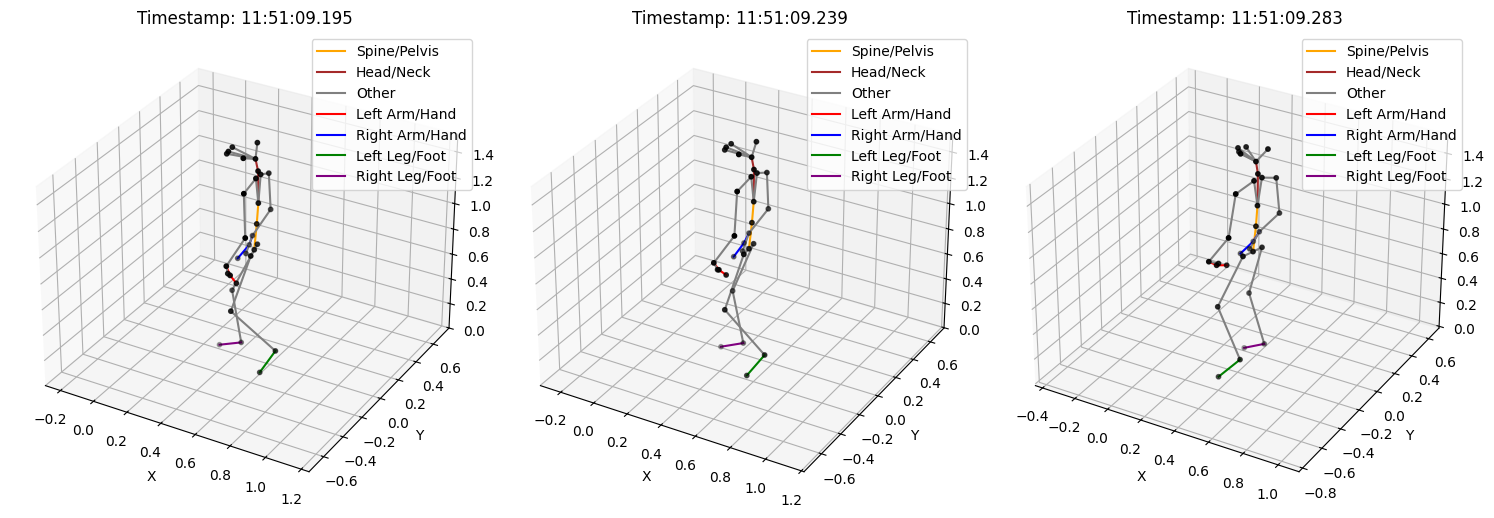

Trial 21 - Gait Type: lurching


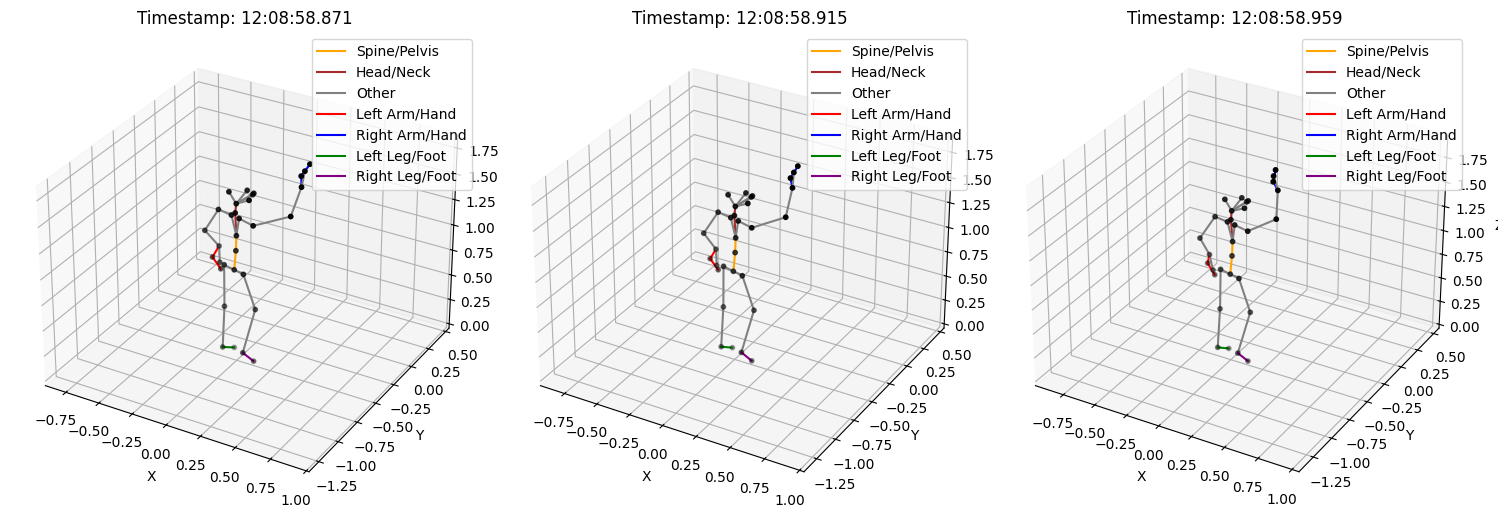

Trial 41 - Gait Type: normal


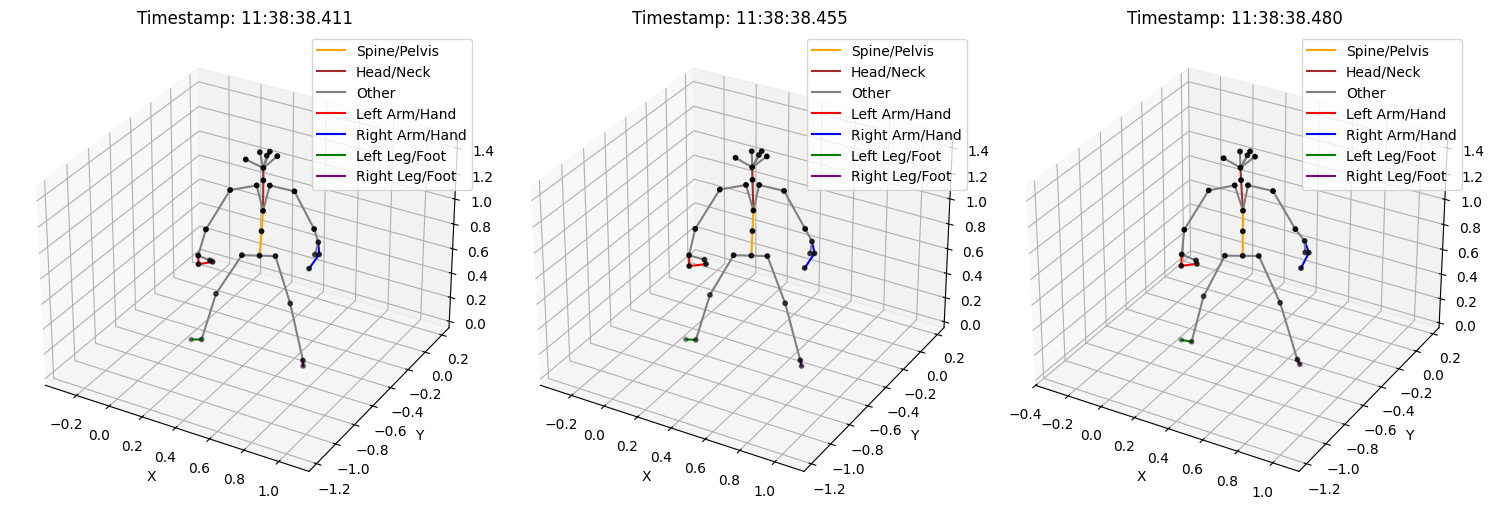

In [15]:
# Helper function to plot a single skeleton frame in 3D
def df_to_arr(df: pd.DataFrame) -> np.ndarray:
    """(T,96)->(T,32,3) using renamed columns."""
    arr = df.values.astype(np.float64)
    T = arr.shape[0]
    return arr.reshape(T, 32, 3)

def plot_skeleton(ax, frame_data, df_joints):
    """
    Plots a single skeleton frame's joint positions in 3D.

    Args:
        ax: Matplotlib 3D axes object.
        frame_data: NumPy array of shape (32, 3) representing joint coordinates.
        df_joints: DataFrame containing joint hierarchy information.
    """
    # Define colors for different body segments
    colors = {
        "left_arm": "red", "right_arm": "blue",
        "left_leg": "green", "right_leg": "purple",
        "spine": "orange", "head": "brown",
        "hand_l": "cyan", "hand_r": "magenta",
        "foot_l": "lime", "foot_r": "teal"
    }

    # Define connections based on the joint hierarchy
    connections = []
    for index, row in df_joints.iterrows():
        parent_name = row["Joint Parent"]
        if parent_name != "-":
            parent_index = df_joints.loc[parent_name, "Joint Index"]
            connections.append((row["Joint Index"], parent_index))

    # Plot joints
    ax.scatter(frame_data[:, 0], frame_data[:, 1], frame_data[:, 2], c='black', marker='o', s=10)

    # Plot bones (connections) and collect handles for legend
    legend_handles = {}
    for joint1_idx, joint2_idx in connections:
        x = [frame_data[joint1_idx, 0], frame_data[joint2_idx, 0]]
        y = [frame_data[joint1_idx, 1], frame_data[joint2_idx, 1]]
        z = [frame_data[joint1_idx, 2], frame_data[joint2_idx, 2]]

        # Determine color based on segment (basic)
        color = 'gray' # Default
        label = 'Other'
        if "LEFT" in df_joints.index[joint1_idx].upper() and "LEFT" in df_joints.index[joint2_idx].upper():
            if "ARM" in df_joints.index[joint1_idx].upper() or "HAND" in df_joints.index[joint1_idx].upper():
                color = colors["left_arm"]
                label = "Left Arm/Hand"
            elif "LEG" in df_joints.index[joint1_idx].upper() or "FOOT" in df_joints.index[joint1_idx].upper():
                color = colors["left_leg"]
                label = "Left Leg/Foot"
        elif "RIGHT" in df_joints.index[joint1_idx].upper() and "RIGHT" in df_joints.index[joint2_idx].upper():
            if "ARM" in df_joints.index[joint1_idx].upper() or "HAND" in df_joints.index[joint1_idx].upper():
                color = colors["right_arm"]
                label = "Right Arm/Hand"
            elif "LEG" in df_joints.index[joint1_idx].upper() or "FOOT" in df_joints.index[joint1_idx].upper():
                color = colors["right_leg"]
                label = "Right Leg/Foot"
        elif "SPINE" in df_joints.index[joint1_idx].upper() or "PELVIS" in df_joints.index[joint1_idx].upper():
            color = colors["spine"]
            label = "Spine/Pelvis"
        elif "HEAD" in df_joints.index[joint1_idx].upper() or "NECK" in df_joints.index[joint1_idx].upper():
            color = colors["head"]
            label = "Head/Neck"

        line, = ax.plot(x, y, z, c=color, label=label)
        legend_handles[label] = line # Store one handle for each label


    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Skeleton Frame")

    # Set equal aspect ratio
    max_range = np.array([frame_data[:,0].max()-frame_data[:,0].min(),
                          frame_data[:,1].max()-frame_data[:,1].min(),
                          frame_data[:,2].max()-frame_data[:,2].min()]).max()
    mid_x = (frame_data[:,0].max()+frame_data[:,0].min()) * 0.5
    mid_y = (frame_data[:,1].max()+frame_data[:,1].min()) * 0.5
    mid_z = (frame_data[:,2].max()+frame_data[:,2].min()) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # Add legend
    ax.legend(handles=list(legend_handles.values()), labels=list(legend_handles.keys()), loc='upper right', bbox_to_anchor=(1.0, 1.0))


# Select a few trials and timestamps to visualize
selected_trials_indices = [0, 20, 40]  # Example indices
selected_timestamps_per_trial = [0, 1, 2] # Example time step indices

for trial_idx in selected_trials_indices:
    df_skel_trial = skeleton_data[trial_idx]
    gait_type = labels[trial_idx]

    print(f"Trial {trial_idx+1} - Gait Type: {gait_type}")

    fig = plt.figure(figsize=(15, 5))

    for i, ts_idx in enumerate(selected_timestamps_per_trial):
        if ts_idx < len(df_skel_trial):
            ax = fig.add_subplot(1, len(selected_timestamps_per_trial), i + 1, projection='3d')
            frame_data = df_to_arr(df_skel_trial.iloc[[ts_idx]])[0] # Get data for the specific timestamp
            plot_skeleton(ax, frame_data, df_joints)
            ax.set_title(f"Timestamp: {df_skel_trial.index[ts_idx].strftime('%H:%M:%S.%f')[:-3]}")
        else:
             print(f"Timestamp index {ts_idx} out of bounds for trial {trial_idx+1}")


    plt.tight_layout()
    plt.show()

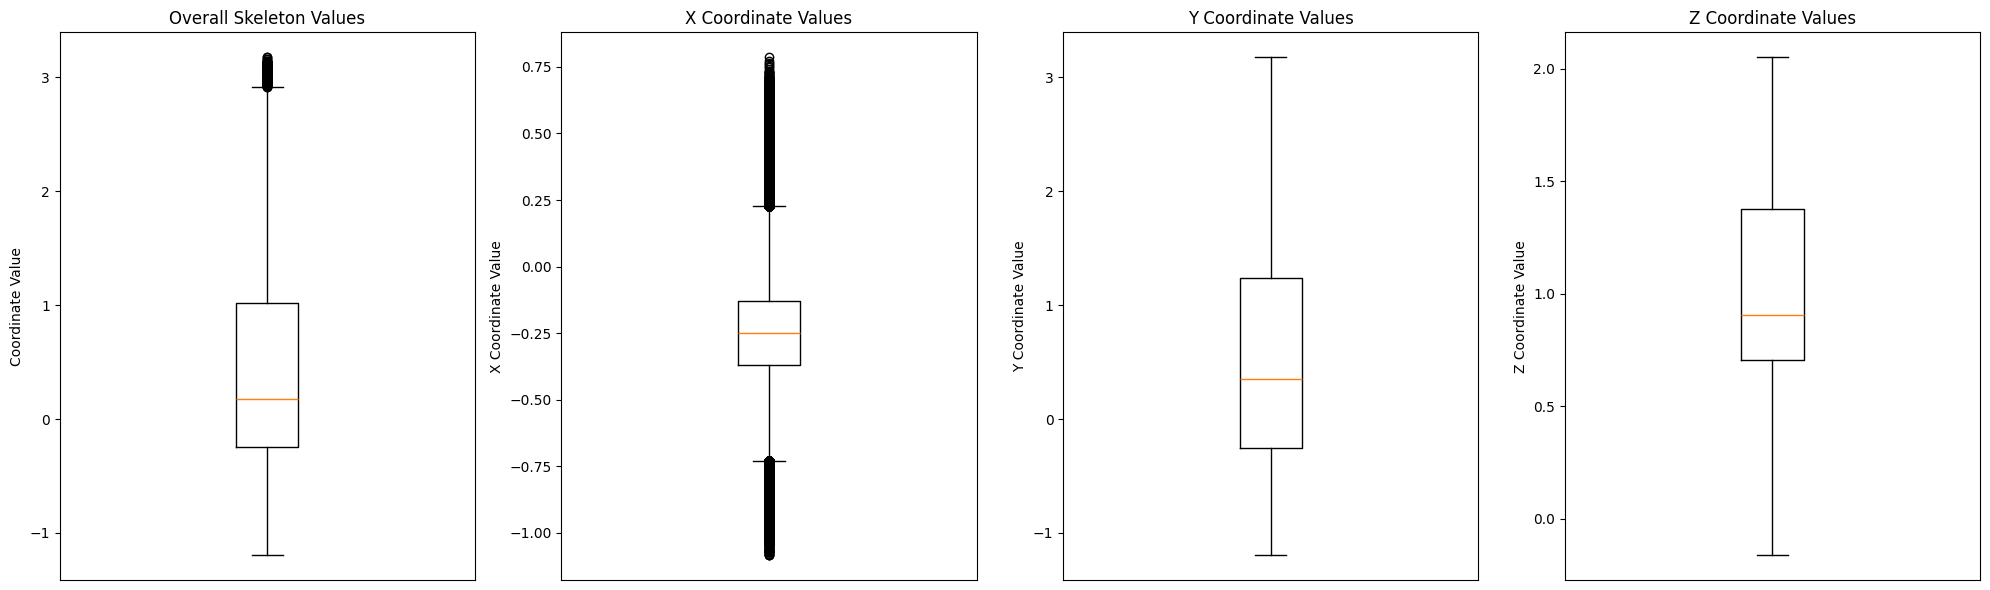

In [16]:
# Analyze the distribution of skeleton data by axis
skeleton_values = np.concatenate([df.values.flatten() for df in skeleton_data])

# Separate and analyze distributions for x, y, and z coordinates
x_values = np.concatenate([df.iloc[:, 0::3].values.flatten() for df in skeleton_data])
y_values = np.concatenate([df.iloc[:, 1::3].values.flatten() for df in skeleton_data])
z_values = np.concatenate([df.iloc[:, 2::3].values.flatten() for df in skeleton_data])

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Box plot for overall skeleton values
axes[0].boxplot(skeleton_values, showfliers=True)
axes[0].set_title("Overall Skeleton Values")
axes[0].set_ylabel("Coordinate Value")
axes[0].set_xticks([]) # Hide x-axis ticks

# Box plot for x-coordinates
axes[1].boxplot(x_values, showfliers=True)
axes[1].set_title("X Coordinate Values")
axes[1].set_ylabel("X Coordinate Value")
axes[1].set_xticks([])

# Box plot for y-coordinates
axes[2].boxplot(y_values, showfliers=True)
axes[2].set_title("Y Coordinate Values")
axes[2].set_ylabel("Y Coordinate Value")
axes[2].set_xticks([])

# Box plot for z-coordinates
axes[3].boxplot(z_values, showfliers=True)
axes[3].set_title("Z Coordinate Values")
axes[3].set_ylabel("Z Coordinate Value")
axes[3].set_xticks([])

plt.tight_layout()
plt.show()

#### Skeleton Data Normalization and Standardization

We normalize skeleton trials in 4 steps to remove nuisance factors while keeping gait‐discriminative motion. Inspired by `Vox & Wallhoff (2018). "Preprocessing and Normalization of 3D-Skeleton-Data for Human Motion Recognition".`:

- Center on pelvis (per frame) → removes global translation bias.

- Scale by stature proxy (per trial) → removes body‐size bias.

- Global z‐score (it will be fit on train only) → consistent scaling, prevents per‐trial flattening & data leakage.

- Add joint angles (hip/knee/ankle/shoulder) → invariant, clinically meaningful features.

This pipeline reduces bias from position, height, and trial‐specific scaling, yielding robust inputs for gait recognition.

In [17]:
# Normalization functions for skeleton_data

# --- joints & geometry ---
def name_to_idx(df_joints, name: str) -> int:
    return int(df_joints.loc[name, "Joint Index"])

def df_to_arr(df: pd.DataFrame) -> np.ndarray:
    """(T,96)->(T,32,3) using renamed columns."""
    arr = df.values.astype(np.float64)
    T = arr.shape[0]
    return arr.reshape(T, 32, 3)

def arr_to_df(arr: np.ndarray, template_df: pd.DataFrame) -> pd.DataFrame:
    T = arr.shape[0]
    out = arr.reshape(T, 32*3)
    return pd.DataFrame(out, index=template_df.index, columns=template_df.columns)

def safe_norm(v: np.ndarray, axis=-1, keepdims=False, eps=1e-8) -> np.ndarray:
    n = np.linalg.norm(v, axis=axis, keepdims=keepdims)
    return np.maximum(n, eps)

def angle_at_joint(a: np.ndarray, b: np.ndarray, c: np.ndarray, degrees: bool = True) -> np.ndarray:
    BA = a - b
    BC = c - b
    BA_n = BA / safe_norm(BA, axis=1, keepdims=True)
    BC_n = BC / safe_norm(BC, axis=1, keepdims=True)
    cosang = np.clip(np.sum(BA_n * BC_n, axis=1), -1.0, 1.0)
    ang = np.arccos(cosang)
    return np.degrees(ang) if degrees else ang

# --- centering by pelvis per frame ---
def center_by_pelvis(arr: np.ndarray, pelvis_idx: int) -> np.ndarray:
    pelvis = arr[:, pelvis_idx, :]             # (T,3)
    return arr - pelvis[:, None, :]            # broadcast to (T,32,3)

# --- stature proxy (trial-level scalar) ---
def segment_len(arr: np.ndarray, i: int, j: int) -> np.ndarray:
    v = arr[:, j, :] - arr[:, i, :]
    return np.linalg.norm(v, axis=1)

def body_scale_proxy(arr: np.ndarray, df_joints: pd.DataFrame) -> float:
    names = ["HIP_LEFT","KNEE_LEFT","ANKLE_LEFT",
             "HIP_RIGHT","KNEE_RIGHT","ANKLE_RIGHT",
             "PELVIS","NECK"]
    J = {n: name_to_idx(df_joints, n) for n in names}
    L_thigh_L = segment_len(arr, J["HIP_LEFT"],   J["KNEE_LEFT"])
    L_shank_L = segment_len(arr, J["KNEE_LEFT"],  J["ANKLE_LEFT"])
    L_thigh_R = segment_len(arr, J["HIP_RIGHT"],  J["KNEE_RIGHT"])
    L_shank_R = segment_len(arr, J["KNEE_RIGHT"], J["ANKLE_RIGHT"])
    L_trunk   = segment_len(arr, J["PELVIS"],     J["NECK"])
    per_frame = (L_thigh_L + L_shank_L + L_thigh_R + L_shank_R + L_trunk) / 5.0
    s = np.nanmedian(per_frame)
    if not np.isfinite(s) or s <= 1e-6:
        s = 1.0
    return float(s)

def scale_by_stature(arr: np.ndarray, scale: float) -> np.ndarray:
    return arr / scale

# --- global standardization (fit on train) ---
def fit_global_standardizer(arr_list_center_scaled: list) -> tuple[np.ndarray, np.ndarray]:
    mats = [a.reshape(-1, 32*3) for a in arr_list_center_scaled if a.size > 0]
    stacked = np.vstack(mats)
    mean96 = stacked.mean(axis=0)
    std96  = stacked.std(axis=0)
    std96[std96 == 0.0] = 1e-8
    return mean96, std96

def apply_global_standardizer(arr: np.ndarray, mean96: np.ndarray, std96: np.ndarray) -> np.ndarray:
    T = arr.shape[0]
    flat = arr.reshape(T, 32*3)
    norm = (flat - mean96) / std96
    return norm.reshape(T, 32, 3)

# --- joint-angle features (sagittal-like proxies from 3D) ---
def extract_gait_angles(arr: np.ndarray, df_joints: pd.DataFrame, degrees: bool = True) -> pd.DataFrame:
    J = {n: name_to_idx(df_joints, n) for n in [
        "PELVIS", "HIP_LEFT", "KNEE_LEFT", "ANKLE_LEFT", "FOOT_LEFT",
        "HIP_RIGHT","KNEE_RIGHT","ANKLE_RIGHT","FOOT_RIGHT",
        "SPINE_CHEST","CLAVICLE_LEFT","SHOULDER_LEFT","ELBOW_LEFT",
        "CLAVICLE_RIGHT","SHOULDER_RIGHT","ELBOW_RIGHT"
    ]}
    def JXYZ(name): return arr[:, J[name], :]
    angles = {
        "knee_L":     angle_at_joint(JXYZ("HIP_LEFT"),   JXYZ("KNEE_LEFT"),   JXYZ("ANKLE_LEFT"),  degrees),
        "knee_R":     angle_at_joint(JXYZ("HIP_RIGHT"),  JXYZ("KNEE_RIGHT"),  JXYZ("ANKLE_RIGHT"), degrees),
        "hip_L":      angle_at_joint(JXYZ("PELVIS"),     JXYZ("HIP_LEFT"),    JXYZ("KNEE_LEFT"),   degrees),
        "hip_R":      angle_at_joint(JXYZ("PELVIS"),     JXYZ("HIP_RIGHT"),   JXYZ("KNEE_RIGHT"),  degrees),
        "ankle_L":    angle_at_joint(JXYZ("KNEE_LEFT"),  JXYZ("ANKLE_LEFT"),  JXYZ("FOOT_LEFT"),   degrees),
        "ankle_R":    angle_at_joint(JXYZ("KNEE_RIGHT"), JXYZ("ANKLE_RIGHT"), JXYZ("FOOT_RIGHT"),  degrees),
        "shoulder_L": angle_at_joint(JXYZ("CLAVICLE_LEFT"), JXYZ("SHOULDER_LEFT"), JXYZ("ELBOW_LEFT"),  degrees),
        "shoulder_R": angle_at_joint(JXYZ("CLAVICLE_RIGHT"),JXYZ("SHOULDER_RIGHT"),JXYZ("ELBOW_RIGHT"), degrees),
    }
    return pd.DataFrame(angles, index=np.arange(arr.shape[0]))

# --- ANGLES: deterministic scaling to [-1, 1] on the physical range [0°, 180°] ---
def angles_to_unit_interval(angle_df: pd.DataFrame) -> pd.DataFrame:
    # Map [0,180] -> [-1,1]
    return 2.0 * (angle_df / 180.0) - 1.0


# ---------- VELOCITIES: compute on centered+scaled arrays ----------
def dt_seconds_from_index(df: pd.DataFrame) -> np.ndarray:
    """Return dt (s) per frame from a DateTimeIndex, length T. First dt = median of diffs."""
    dt = df.index.to_series().diff().dt.total_seconds().to_numpy()
    if len(dt) == 0:
        return dt
    # replace non-positive/NaN with median positive dt
    pos = dt[(dt > 0) & np.isfinite(dt)]
    med = np.median(pos) if pos.size else 1.0
    dt[0] = med
    dt[~np.isfinite(dt) | (dt <= 0)] = med
    return dt

def velocities_center_scaled(arr_cs: np.ndarray,
                             dt_seconds: np.ndarray,
                             pelvis_relative: bool = True,
                             speed_normalize: bool = True) -> np.ndarray:
    """
    Compute joint linear velocities from centered+scaled positions.
    arr_cs: (T,32,3) positions already centered on pelvis and scaled by stature.
    dt_seconds: (T,) time delta per frame in seconds.
    Returns (T,32,3); first row is zeros.
    """
    if arr_cs.shape[0] != dt_seconds.shape[0]:
        raise ValueError("arr_cs and dt_seconds must have same T.")
    # finite dt guard
    dt = dt_seconds.copy()
    dt[~np.isfinite(dt) | (dt <= 0)] = np.nanmedian(dt[np.isfinite(dt) & (dt > 0)])
    # differenze e divisione per dt
    v = np.diff(arr_cs, axis=0) / dt[1:, None, None]  # (T-1,32,3)
    # pelvis-relative
    if pelvis_relative:
        pelvis_v = v[:, 0:1, :]                       # PELVIS è joint 0
        v = v - pelvis_v
    # speed-normalize by forward pelvis speed (|vy|)
    if speed_normalize:
        vy = np.abs((v + (pelvis_v if pelvis_relative else 0))[:, 0, 1]) if pelvis_relative else np.abs(v[:, 0, 1])
        s = np.nanmedian(vy)
        if np.isfinite(s) and s > 1e-6:
            v = v / s
    # prepend zeros to match length T
    v0 = np.zeros((1, v.shape[1], v.shape[2]), dtype=v.dtype)
    return np.concatenate([v0, v], axis=0)

# ---------- VELOCITIES: fit/apply global z-score (TRAIN only) ----------
def fit_velocity_scaler(vel_arr_list: list[np.ndarray]) -> tuple[np.ndarray, np.ndarray]:
    """Fit mean/std over flattened 96-D velocity features across TRAIN trials."""
    mats = [a.reshape(-1, 32*3) for a in vel_arr_list if a.size > 0]
    stacked = np.vstack(mats)
    mean96 = stacked.mean(axis=0)
    std96  = stacked.std(axis=0)
    std96[std96 == 0] = 1e-8
    return mean96, std96

def apply_velocity_scaler(vel_arr: np.ndarray,
                          mean96: np.ndarray,
                          std96: np.ndarray,
                          clip_z: float | None = 5.0) -> np.ndarray:
    T = vel_arr.shape[0]
    flat = vel_arr.reshape(T, 96)
    z = (flat - mean96) / std96
    if clip_z is not None:
        z = np.clip(z, -clip_z, clip_z)
    return z.reshape(T, 32, 3)

# --- single-trial preprocessing (steps 1–2) ---
def preprocess_trial_positions(df_trial: pd.DataFrame, df_joints: pd.DataFrame) -> tuple[np.ndarray, float]:
    pelvis_idx = name_to_idx(df_joints, "PELVIS")
    arr = df_to_arr(df_trial)
    arr = center_by_pelvis(arr, pelvis_idx)
    s = body_scale_proxy(arr, df_joints)
    arr = scale_by_stature(arr, s)
    return arr, s

# --- fit stats on TRAIN split only ---
def fit_global_stats_on_train(skeleton_data_train: list[pd.DataFrame],
                              df_joints: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, list[np.ndarray]]:
    train_arrs = []
    for sk in skeleton_data_train:
        arr_cs, _ = preprocess_trial_positions(sk, df_joints)
        if arr_cs.size > 0:
            train_arrs.append(arr_cs)
    mean96, std96 = fit_global_standardizer(train_arrs)
    return mean96, std96, train_arrs

# --- apply to ALL trials + optional angles ---
def apply_full_preprocessing(skeleton_data: list[pd.DataFrame],
                             df_joints: pd.DataFrame,
                             mean96: np.ndarray,
                             std96: np.ndarray,
                             return_angles: bool = True,
                             return_vel: bool = True) -> dict:
    pos_arrs, pos_df_list, angle_df_list, feat_concat_list, vel_arr_list = [], [], [], [], []
    for df in skeleton_data:
        arr_cs, _ = preprocess_trial_positions(df, df_joints)
        arr_norm = apply_global_standardizer(arr_cs, mean96, std96)
        pos_arrs.append(arr_norm)
        pos_df_list.append(arr_to_df(arr_norm, df))
        if return_angles:
            # angles on centered+scaled (before z-score) to keep absolute magnitudes
            ang_df = extract_gait_angles(arr_cs, df_joints, degrees=True)
            ang_df = angles_to_unit_interval(ang_df)
            angle_df_list.append(ang_df)
            flat_pos = arr_norm.reshape(arr_norm.shape[0], 32*3)
            feat_concat_list.append(np.hstack([flat_pos, ang_df.values]))
        if return_vel:
            dt = dt_seconds_from_index(df)
            vel_cs = velocities_center_scaled(arr_cs, dt, pelvis_relative=True, speed_normalize=True)
            vel_arr_list.append(vel_cs)
    out = {"pos_arrs": pos_arrs, "pos_df": pos_df_list}
    if return_angles:
        out["angles"] = angle_df_list
        out["features_concat"] = feat_concat_list
    if return_vel:
        out["vel_arrs"] = vel_arr_list
    return out

#### Sequence-length analysis and unification

Training requires tensors of shape `(N, T, F)` with the same `T`. The chosen `T` trades off information loss (truncation) vs. noise/inefficiency (padding).

In order to choose `T = MAX_TIMESTEPS` in a consistent way:

- We measure how many time steps each trial has (descriptive stats + histogram).  
- We then choose a target length `MAX_TIMESTEPS` that balances coverage (few truncated trials) and padding overhead.  
- This way we make all trials uniform: truncate longer ones and pad shorter ones with a neutral value (0.0) so models can batch them easily.

To make all trials uniform, we use `tf.keras.utils.pad_sequences` with `truncating="pre"` (keep the **last** part) and `padding="post"` (zeros at the end), plus a `Masking(mask_value=0.0)` layer so padded frames are ignored.


Trials: 1440
Distribution of skeleton time steps across trials:


count    1440.000000
mean      195.250694
std        42.349685
min       101.000000
25%       164.000000
50%       194.000000
75%       224.000000
max       433.000000
Name: n_timesteps, dtype: float64

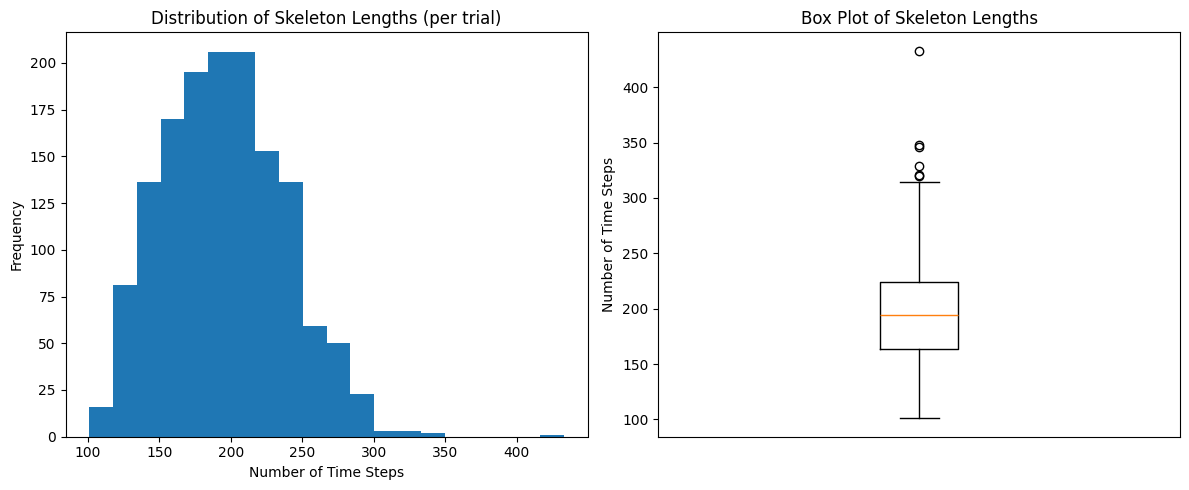

In [18]:
print(f"Trials: {len(skeleton_data)}")
print("Distribution of skeleton time steps across trials:")
# quick coverage table to guide the choice of MAX_TIMESTEPS
display(pd.Series(n_ts_skel, name="n_timesteps").describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
axes[0].hist(n_ts_skel, bins=20)
axes[0].set_xlabel("Number of Time Steps")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Skeleton Lengths (per trial)")

# Box plot
axes[1].boxplot(n_ts_skel)
axes[1].set_ylabel("Number of Time Steps")
axes[1].set_title("Box Plot of Skeleton Lengths")
axes[1].set_xticks([]) # Hide x-axis ticks for the box plot

plt.tight_layout()
plt.show()

**Observation.**  
Lengths cluster around the median (~194) with IQR 164–224 and a long right tail up to 433.

**Decision.**  
Set **`MAX_TIMESTEPS`** at the beginning in the CONFIG setup (≈ 75th percentile or 95th percentile): ~75%/95% of trials won’t be truncated and padding stays moderate.


**Inspecting coordinates (x, y, z) on extreme trials**

**What we do.**  
Plot the coordinates for the **longest** and **shortest** trials to decide **where to truncate** (beginning vs. end) and **where to pad** (start vs. end).

**Why.**  
If walking is most stable at the end, we keep the **last** frames and cut the start; if stability is at the beginning, we do the opposite.  
Similarly, post-padding keeps sequences left-aligned in time.

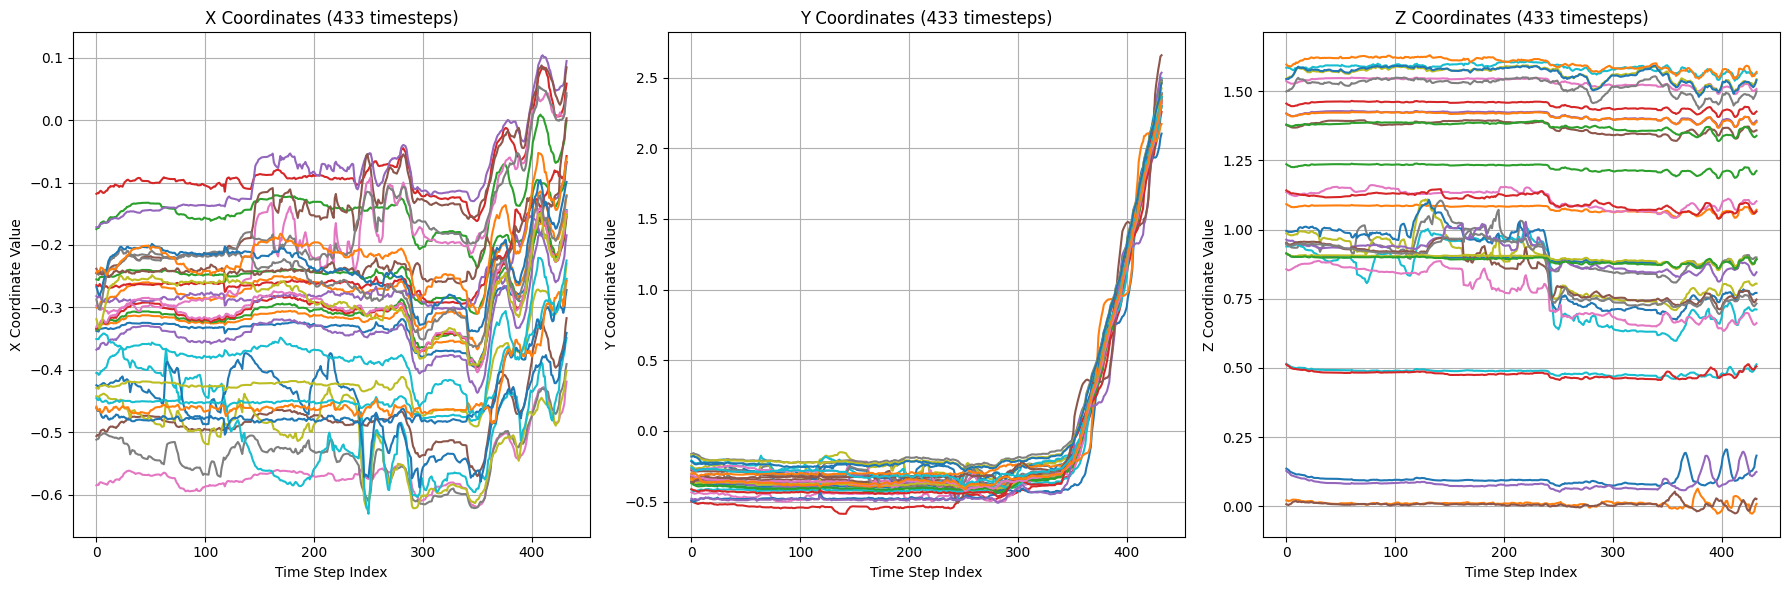

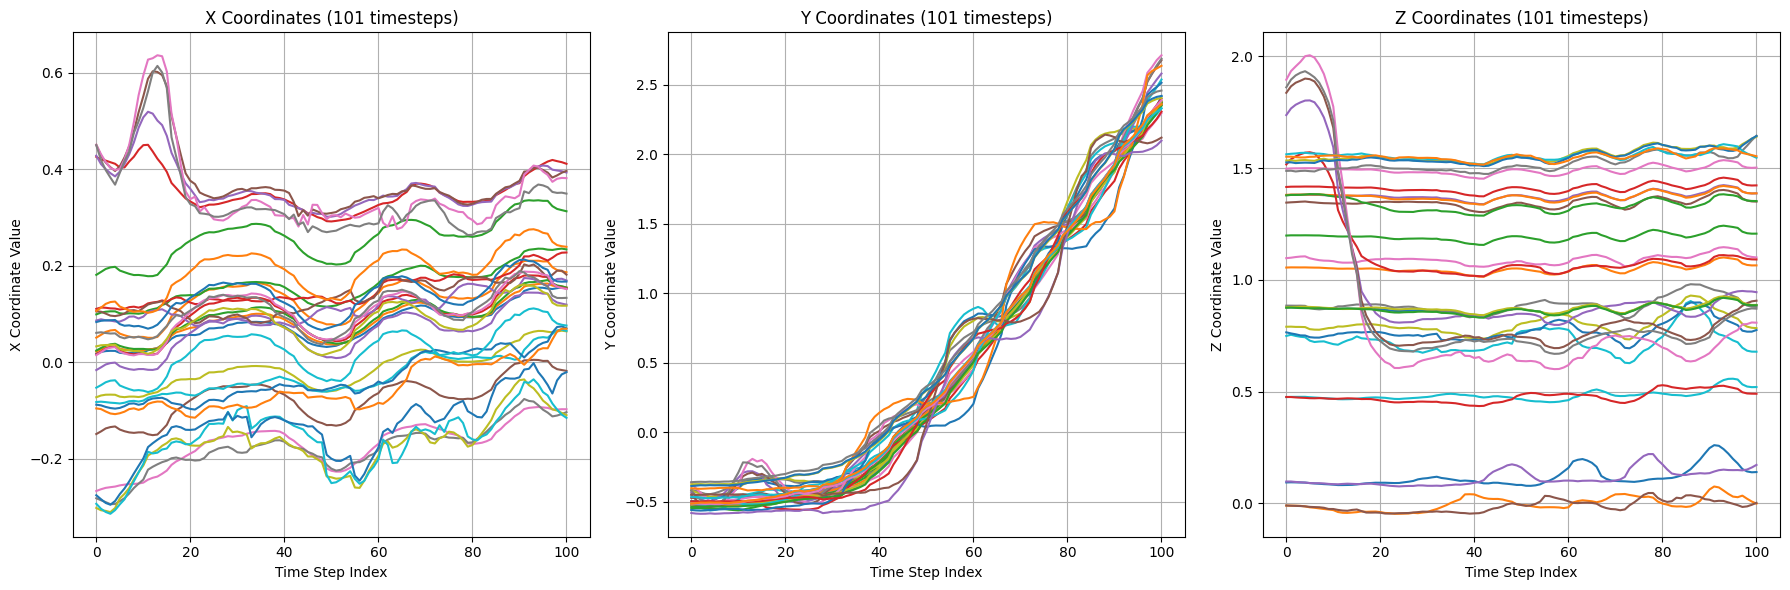

In [19]:
ts = pd.Series(n_ts_skel, name="n_timesteps")
df_skel_max = skeleton_data[ts.idxmax()]
df_skel_min = skeleton_data[ts.idxmin()]

df_to_plot = [df_skel_max, df_skel_min]

for df_skel in df_to_plot:
    x_cols = df_skel.columns[0::3]
    y_cols = df_skel.columns[1::3]
    z_cols = df_skel.columns[2::3]

    x_values = range(len(df_skel))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Create a figure with 3 subplots

    # Plot x-coordinates
    for col in x_cols:
        axes[0].plot(x_values, df_skel[col])
    axes[0].set_xlabel("Time Step Index")
    axes[0].set_ylabel("X Coordinate Value")
    axes[0].set_title(f"X Coordinates ({len(df_skel)} timesteps)")
    axes[0].grid(True)

    # Plot y-coordinates
    for col in y_cols:
        axes[1].plot(x_values, df_skel[col])
    axes[1].set_xlabel("Time Step Index")
    axes[1].set_ylabel("Y Coordinate Value")
    axes[1].set_title(f"Y Coordinates ({len(df_skel)} timesteps)")
    axes[1].grid(True)

    # Plot z-coordinates
    for col in z_cols:
        axes[2].plot(x_values, df_skel[col])
    axes[2].set_xlabel("Time Step Index")
    axes[2].set_ylabel("Z Coordinate Value")
    axes[2].set_title(f"Z Coordinates ({len(df_skel)} timesteps)")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

**Truncation & Padding — Final Choice**

**Evidence from the plots.**  
- Forward axis **y** shows a **brief initial transient**, then **stable, continuous walking** all the way to the end (no stopping/turning).  
- Lateral **x** and vertical **z** maintain **consistent periodic oscillations** throughout.
- Gait is stable through the final frames, hence **keeping the last segment** preserves **complete, clean gait cycles** and avoids discarding good data at the end.  

**Decision.**  
- **Truncate the start → keep the last part.**  
  → **`truncating="pre"`**

- **Post-padding (zeros at the end).**  
  **Left-aligns** sequences in time, **avoids artificial gaps at the start**, and lets a **`Masking(mask_value=0.0)`** layer ignore padded frames.  
  With global z-scoring, **0.0 is neutral**, so padding does not bias the features.  
  → We use **`padding="post"`** with **`value=0.0`**.

- **Masking:** use `Masking(mask_value=0.0)` so padded frames don’t affect learning.

Function to unify sequence length to `MAX_TIMESTEPS` with `pad_sequences`

We support two modes:
1) **Positions only** (96 features).  
2) **Positions + joint angles** (add clinically meaningful angle features).

In [20]:
def build_uniform_sequences(
    skeleton_data_norm,
    max_timesteps: int,
    truncating: str = "pre",   # keep last part
    padding: str = "post",     # pad at the end
    pad_value: float = 0.0
):
    """
    Preprocess and unify trials to (N, max_timesteps, F) with padding/truncation.

    Args:
      skeleton_data_norm: list of DataFrame of normalized skeleton_data (output of apply_full_preprocessing() fiunction).
      max_timesteps: target sequence length.
      truncating: "pre" (drop the beginning) or "post" (drop the end).
      padding: "post" (pad at the end) or "pre" (pad at the start).
      pad_value: padding value (0.0 recommended after z-score).

    Returns:
      X: np.ndarray of shape (N, max_timesteps, F)
      skeleton_data_norm: list of DataFrames
      F: feature dimension per time step
    """

    # Build per-trial feature matrices
    seq_list = [pos_df.values.astype("float32") for pos_df in skeleton_data_norm]

    F = seq_list[0].shape[1] if len(seq_list) else 0

    # Pad/trim to uniform length
    X = pad_sequences(
        seq_list,
        maxlen=max_timesteps,
        dtype="float32",
        padding=padding,
        truncating=truncating,
        value=pad_value
    )
    return X, skeleton_data_norm, F



### **Pressure Data Description and Visualization**

**Average foot pressure data**

Obtained by GW1100 (size = 48 x 128).

GW1100 is a 1080mm x 480mm sized pressure plate and contains 6,144 high-voltage matrix sensors with maximum pressure 100 N/cm^2.

Display the head of one of the loaded pressure DataFrames to show its structure and content.

In [21]:
df_press.head()

0   1   2   3   4   5   6   7   8   9   ...  38  39  40  41  42  43  44  \
0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

   45  46  47  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0  

[5 rows x 48 columns]

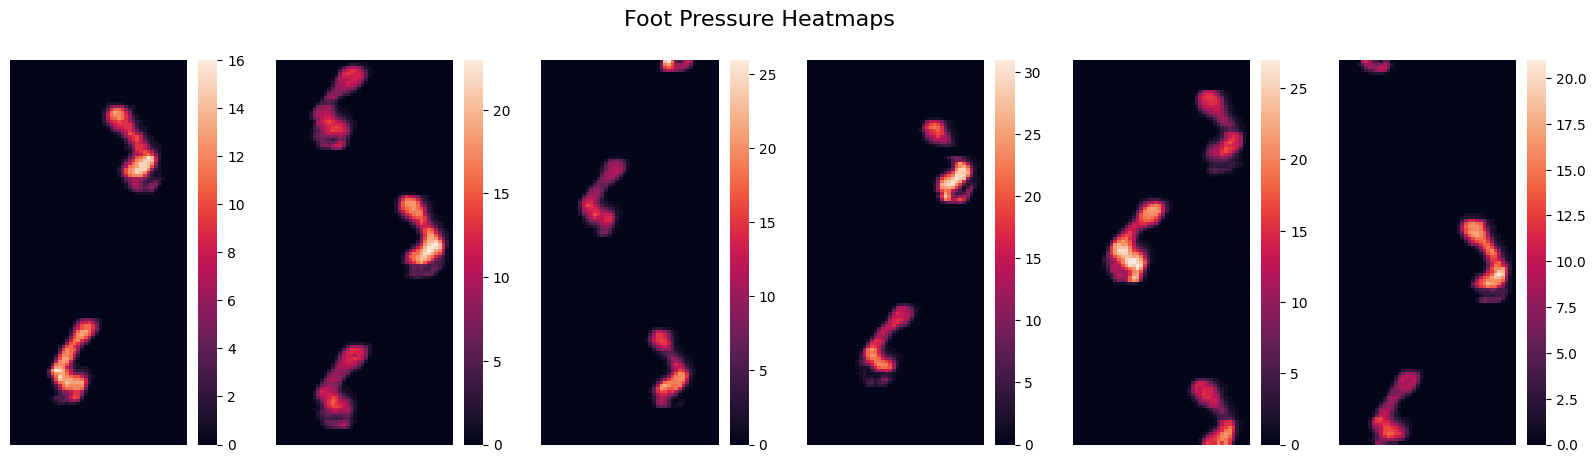

In [22]:
random_indices = np.random.choice(len(pressure_data), 6, replace=False)
selected_samples = [pressure_data[i] for i in random_indices]

# Heatmaps
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

for idx, ax in enumerate(axes):
    sns.heatmap(selected_samples[idx], ax=ax, cbar=True)
    ax.axis("off")

plt.suptitle("Foot Pressure Heatmaps", fontsize=16)
plt.show()

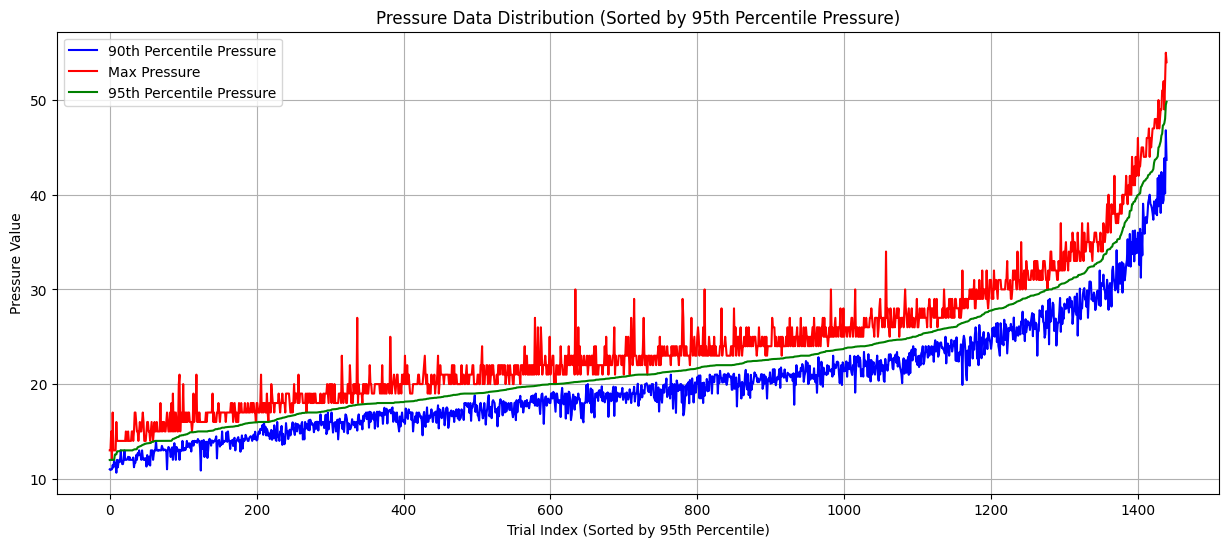

In [23]:
min_vals = [df[df>0].min().min() for df in pressure_data]
max_vals = [df[df>0].max().max() for df in pressure_data]
perc90_vals = [df[df>0].quantile(0.90).quantile(0.90) for df in pressure_data]
perc95_vals = [df[df>0].quantile(0.95).quantile(0.95) for df in pressure_data]
min_max_df = pd.DataFrame({"min": min_vals, "max": max_vals, "90%": perc90_vals, "95%": perc95_vals})

# Sort the DataFrame by the '95%' column
df_sorted = min_max_df.sort_values(by='95%')

# Plot the three series in a single plot with different colors
plt.figure(figsize=(15, 6))
plt.plot(range(len(df_sorted)), df_sorted['90%'], label='90th Percentile Pressure', color='blue')
plt.plot(range(len(df_sorted)), df_sorted['max'], label='Max Pressure', color='red')
plt.plot(range(len(df_sorted)), df_sorted['95%'], label='95th Percentile Pressure', color='green')

plt.title("Pressure Data Distribution (Sorted by 95th Percentile Pressure)")
plt.xlabel("Trial Index (Sorted by 95th Percentile)")
plt.ylabel("Pressure Value")
plt.legend()
plt.grid(True)
plt.show()

# display(df_sorted)

In [24]:
def normalize_pressure_data(pressure_df):
    min_val = pressure_df.min().min()
    max_val = pressure_df[pressure_df>0].quantile(0.95).quantile(0.95)
    if max_val - min_val == 0: # To prevent dividing by zero
        normalized_df = pressure_df - min_val
    else:
        normalized_df = (pressure_df - min_val) / (max_val - min_val)
    return normalized_df

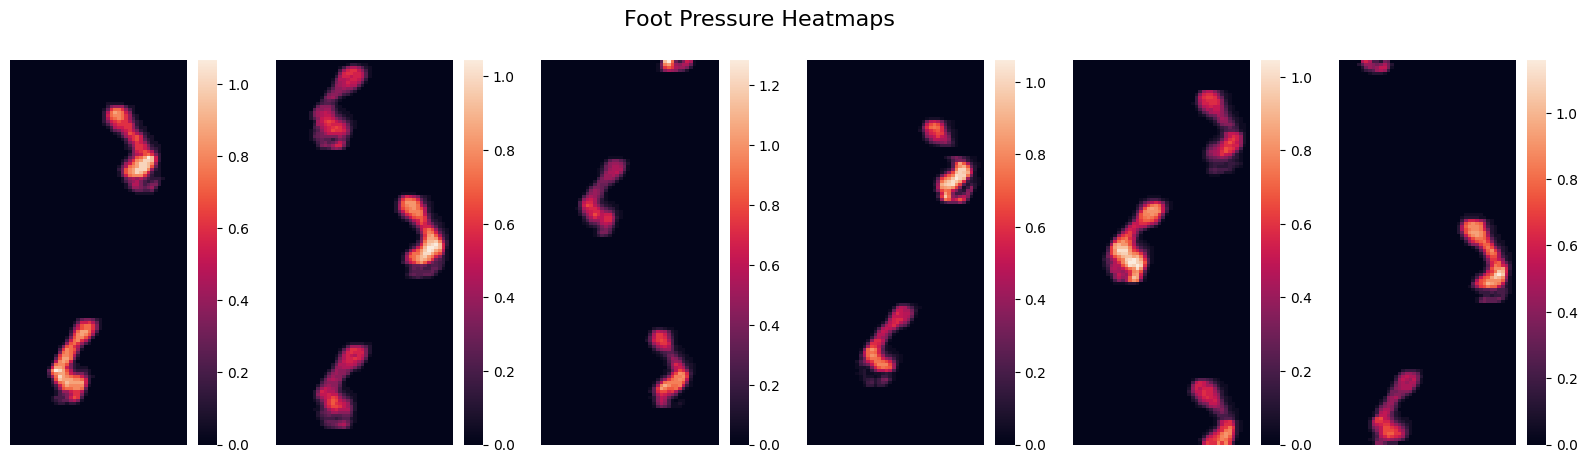

In [25]:
selected_samples = [normalize_pressure_data(pressure_data[i]) for i in random_indices]

# Heatmaps
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

for idx, ax in enumerate(axes):
    sns.heatmap(selected_samples[idx], ax=ax, cbar=True)
    ax.axis("off")

plt.suptitle("Foot Pressure Heatmaps", fontsize=16)
plt.show()

## **Data Preparation**

In [26]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

classes = label_encoder.classes_
class_to_onehot = {cls: labels_onehot[labels_encoded == i][0].tolist()
                   for i, cls in enumerate(classes)}

print(labels_onehot.shape)
display(pd.Series(class_to_onehot, name="labels to one-hot vector"))

(1440, 6)


antalgic         [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lurching         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
normal           [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
steppage         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
stiff-legged     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
trendelenburg    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Name: labels to one-hot vector, dtype: object

In [29]:
# Subject-Aware Data Splitting

# Unique, shuffled list of all subject IDs
# The random state ensures the shuffle is the same every time.
rng = np.random.default_rng(CONFIG['RANDOM_STATE'])
all_subject_ids = df_manifest['subject_id'].unique()
rng.shuffle(all_subject_ids)

# Define split boundaries based on subject counts
n_subjects = len(all_subject_ids)
test_split_idx = int(n_subjects * (1 - CONFIG['TEST_SIZE']))
val_split_idx = int(test_split_idx * (1 - CONFIG['VAL_SIZE']))

# Create lists of subject IDs for each set
train_subjects = all_subject_ids[:val_split_idx]
val_subjects = all_subject_ids[val_split_idx:test_split_idx]
test_subjects = all_subject_ids[test_split_idx:]

print("--- Data Split by Subject ID ---")
print(f"Total Subjects: {n_subjects}")
print(f"Train subjects ({len(train_subjects)}): {train_subjects}")
print(f"Validation subjects ({len(val_subjects)}): {val_subjects}")
print(f"Test subjects ({len(test_subjects)}): {test_subjects}")
print("-" * 30)

# Create a helper function to retrieve all data for a given list of subjects
def get_data_for_subjects(subject_list, manifest_df, all_sk, all_pr, all_labels):
    """Filters all data sources based on a list of subject IDs."""
    # Find the original indices of the trials belonging to the subjects
    indices = manifest_df[manifest_df['subject_id'].isin(subject_list)].index

    # Use the indices to gather the corresponding data
    sk_data = [all_sk[i] for i in indices]
    pr_data = [all_pr[i] for i in indices]
    y_labels = all_labels[indices]

    return sk_data, pr_data, y_labels

# Build the final data splits using the helper function
X_train_sk, X_train_pr, y_train = get_data_for_subjects(
    train_subjects, df_manifest, skeleton_data, pressure_data, labels_onehot
)
X_val_sk, X_val_pr, y_val = get_data_for_subjects(
    val_subjects, df_manifest, skeleton_data, pressure_data, labels_onehot
)
X_test_sk, X_test_pr, y_test = get_data_for_subjects(
    test_subjects, df_manifest, skeleton_data, pressure_data, labels_onehot
)

print(f"Train set trials: {len(X_train_sk)}")
print(f"Validation set trials: {len(X_val_sk)}")
print(f"Test set trials: {len(X_test_sk)}")
print("\n✅ Data split avoiding subject leakage.")

--- Data Split by Subject ID ---
Total Subjects: 12
Train subjects (8): [ 1  5  4  7  9 12  3 11]
Validation subjects (2): [2 8]
Test subjects (2): [10  6]
------------------------------
Train set trials: 960
Validation set trials: 240
Test set trials: 240

✅ Data split avoiding subject leakage.


Checking the average length of the sequences in each split.

In [30]:
def get_sequence_lengths(data):
    """Calculate actual sequence lengths (non-zero timesteps) for each sample"""
    lengths = []
    for sample in data:
        # Count non-zero timesteps (assuming padding with zeros)
        # Sum across features to see if any feature is non-zero at each timestep
        non_zero_timesteps = np.sum(np.any(sample != 0, axis=1))
        lengths.append(non_zero_timesteps)
    return np.array(lengths)

# Calculate sequence lengths for each set
train_lengths = get_sequence_lengths(X_train_sk)
val_lengths = get_sequence_lengths(X_val_sk)
test_lengths = get_sequence_lengths(X_test_sk)

# Print statistics
print("=== Sequence Length Statistics ===")
print(f"Train set:")
print(f"  Average length: {np.mean(train_lengths):.2f}")
print(f"  Min length: {np.min(train_lengths)}")
print(f"  Max length: {np.max(train_lengths)}")
print(f"  Std deviation: {np.std(train_lengths):.2f}")

print(f"\nValidation set:")
print(f"  Average length: {np.mean(val_lengths):.2f}")
print(f"  Min length: {np.min(val_lengths)}")
print(f"  Max length: {np.max(val_lengths)}")
print(f"  Std deviation: {np.std(val_lengths):.2f}")

print(f"\nTest set:")
print(f"  Average length: {np.mean(test_lengths):.2f}")
print(f"  Min length: {np.min(test_lengths)}")
print(f"  Max length: {np.max(test_lengths)}")
print(f"  Std deviation: {np.std(test_lengths):.2f}")

# Check if there's a significant difference between sets
print(f"\n=== Length Distribution Comparison ===")
print(f"Train vs Val difference: {abs(np.mean(train_lengths) - np.mean(val_lengths)):.2f}")
print(f"Train vs Test difference: {abs(np.mean(train_lengths) - np.mean(test_lengths)):.2f}")
print(f"Val vs Test difference: {abs(np.mean(val_lengths) - np.mean(test_lengths)):.2f}")

=== Sequence Length Statistics ===
Train set:
  Average length: 193.30
  Min length: 101
  Max length: 348
  Std deviation: 41.45

Validation set:
  Average length: 177.81
  Min length: 113
  Max length: 433
  Std deviation: 35.91

Test set:
  Average length: 220.49
  Min length: 118
  Max length: 314
  Std deviation: 40.42

=== Length Distribution Comparison ===
Train vs Val difference: 15.49
Train vs Test difference: 27.19
Val vs Test difference: 42.68


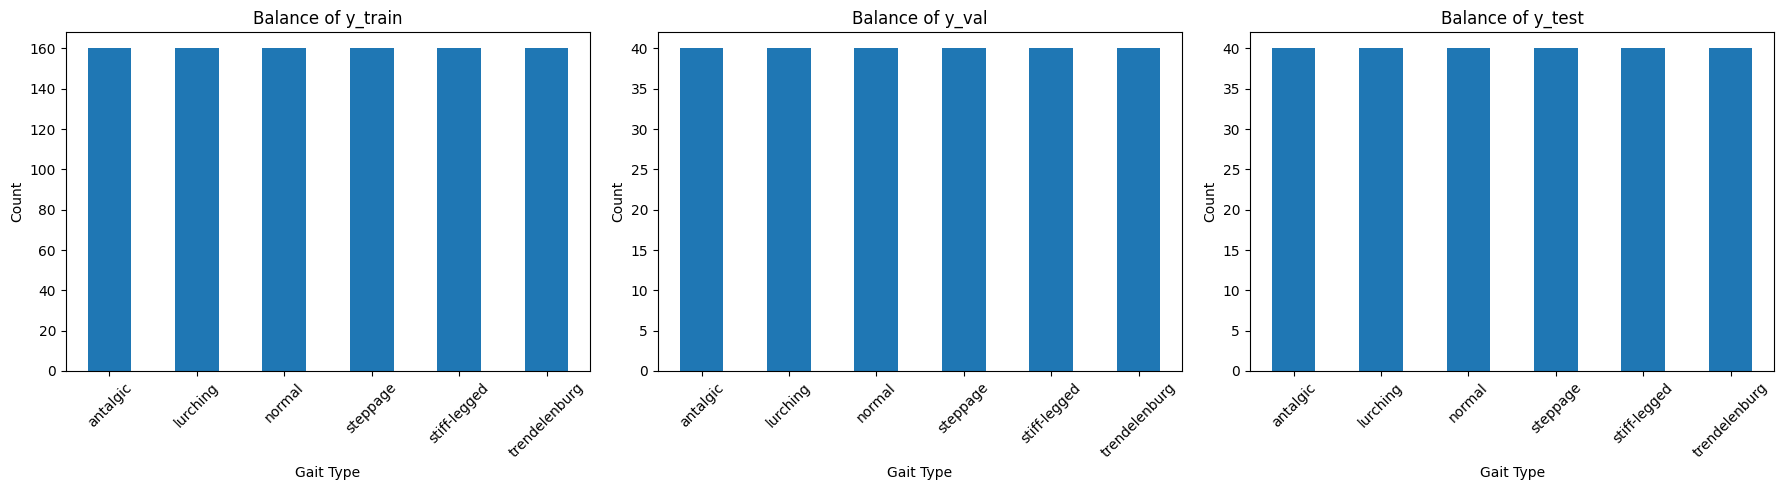

In [31]:
# Check the balance of y_train, y_val, and y_test side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Balance of y_train
y_train_labels = label_encoder.inverse_transform(np.argmax(y_train, axis=1))
train_counts = pd.Series(y_train_labels).value_counts()
train_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title("Balance of y_train")
axes[0].set_xlabel("Gait Type")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Balance of y_val
y_val_labels = label_encoder.inverse_transform(np.argmax(y_val, axis=1))
val_counts = pd.Series(y_val_labels).value_counts()
val_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title("Balance of y_val")
axes[1].set_xlabel("Gait Type")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

# Balance of y_test
y_test_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
test_counts = pd.Series(y_test_labels).value_counts()
test_counts.plot(kind='bar', ax=axes[2])
axes[2].set_title("Balance of y_test")
axes[2].set_xlabel("Gait Type")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [32]:
# 1) Fit global stats on TRAIN
mean96, std96, _ = fit_global_stats_on_train(X_train_sk, df_joints)

# 2) Apply to ALL trials (+ angles)
X_train_sk_dict = apply_full_preprocessing(X_train_sk, df_joints, mean96, std96, return_angles=CONFIG['JOINTS_ANGLES'], return_vel=CONFIG['VELOCITIES'])
X_val_sk_dict = apply_full_preprocessing(X_val_sk, df_joints, mean96, std96, return_angles=CONFIG['JOINTS_ANGLES'], return_vel=CONFIG['VELOCITIES'])
X_test_sk_dict = apply_full_preprocessing(X_test_sk, df_joints, mean96, std96, return_angles=CONFIG['JOINTS_ANGLES'], return_vel=CONFIG['VELOCITIES'])

# Access:
# dict["pos_arrs"]          -> list of (T,32,3) ndarrays
# dict["pos_df"]            -> list of normalized (T,96) DataFrames
# dict["angles"]            -> list of (T,8) DataFrames if CONFIG['JOINTS_ANGLES']==True
# dict["features_concat"]   -> list of (T, 96+8) ndarrays ready for modeling
# dict["vel_arrs"]            -> list of (T,96) DataFrames if CONFIG['VELOCITIES']==True

In [33]:
# choose the target length
#MAX_TIMESTEPS = int(pd.Series(n_ts_skel).quantile(CONFIG['PERC_MAX_TIMESTEPS']))
#print(f'MAX_TIMESTEPS = {MAX_TIMESTEPS}')

MAX_TIMESTEPS = CONFIG['MAX_TIMESTEPS']
print(f'MAX_TIMESTEPS = {MAX_TIMESTEPS}')

MAX_TIMESTEPS = 100


In [34]:
X_train_sk, X_sk_df_train, F_train = build_uniform_sequences(
    X_train_sk_dict["pos_df"],
    MAX_TIMESTEPS,
    truncating = CONFIG['TRUNCATING'],
    padding = CONFIG['PADDING'],
    pad_value = CONFIG['PAD_VALUE']
)
X_val_sk, X_sk_df_val, F_val = build_uniform_sequences(
    X_val_sk_dict["pos_df"],
    MAX_TIMESTEPS,
    truncating = CONFIG['TRUNCATING'],
    padding = CONFIG['PADDING'],
    pad_value = CONFIG['PAD_VALUE']
)
X_test_sk, X_sk_df_test, F_test = build_uniform_sequences(
    X_test_sk_dict["pos_df"],
    MAX_TIMESTEPS,
    truncating = CONFIG['TRUNCATING'],
    padding = CONFIG['PADDING'],
    pad_value = CONFIG['PAD_VALUE']
)

In [35]:
if CONFIG['JOINTS_ANGLES']:

    X_train_angles, X_angles_df_train, _ = build_uniform_sequences(
        X_train_sk_dict["angles"],
        MAX_TIMESTEPS,
        truncating = CONFIG['TRUNCATING'],
        padding = CONFIG['PADDING'],
        pad_value = CONFIG['PAD_VALUE']
    )
    X_val_angles, X_angles_df_val, _ = build_uniform_sequences(
        X_val_sk_dict["angles"],
        MAX_TIMESTEPS,
        truncating = CONFIG['TRUNCATING'],
        padding = CONFIG['PADDING'],
        pad_value = CONFIG['PAD_VALUE']
    )
    X_test_angles, X_angles_df_test, _ = build_uniform_sequences(
        X_test_sk_dict["angles"],
        MAX_TIMESTEPS,
        truncating = CONFIG['TRUNCATING'],
        padding = CONFIG['PADDING'],
        pad_value = CONFIG['PAD_VALUE']
    )

if CONFIG['VELOCITIES']:

    X_train_vel = X_train_sk_dict["vel_arrs"]
    X_val_vel = X_val_sk_dict["vel_arrs"]
    X_test_vel = X_test_sk_dict["vel_arrs"]

    vel_mean96, vel_std96 = fit_velocity_scaler(X_train_vel)

    for i, vel_cs in enumerate(X_train_vel):
        vel_z = apply_velocity_scaler(vel_cs, vel_mean96, vel_std96)
        vel_z = arr_to_df(vel_z, X_train_sk_dict["pos_df"][i])
        X_train_vel[i] = vel_z
    for i, vel_cs in enumerate(X_val_vel):
        vel_z = apply_velocity_scaler(vel_cs, vel_mean96, vel_std96)
        vel_z = arr_to_df(vel_z, X_val_sk_dict["pos_df"][i])
        X_val_vel[i] = vel_z
    for i, vel_cs in enumerate(X_test_vel):
        vel_z = apply_velocity_scaler(vel_cs, vel_mean96, vel_std96)
        vel_z = arr_to_df(vel_z, X_test_sk_dict["pos_df"][i])
        X_test_vel[i] = vel_z

    X_train_vel, X_vel_df_train, _ = build_uniform_sequences(
        X_train_vel,
        MAX_TIMESTEPS,
        truncating = CONFIG['TRUNCATING'],
        padding = CONFIG['PADDING'],
        pad_value = CONFIG['PAD_VALUE']
    )
    X_val_vel, X_vel_df_val, _ = build_uniform_sequences(
        X_val_vel,
        MAX_TIMESTEPS,
        truncating = CONFIG['TRUNCATING'],
        padding = CONFIG['PADDING'],
        pad_value = CONFIG['PAD_VALUE']
    )
    X_test_vel, X_vel_df_test, _ = build_uniform_sequences(
        X_test_vel,
        MAX_TIMESTEPS,
        truncating = CONFIG['TRUNCATING'],
        padding = CONFIG['PADDING'],
        pad_value = CONFIG['PAD_VALUE']
    )



In [36]:
X_train_pr_norm = [normalize_pressure_data(df) for df in X_train_pr]
X_val_pr_norm = [normalize_pressure_data(df) for df in X_val_pr]
X_test_pr_norm = [normalize_pressure_data(df) for df in X_test_pr]

X_train_pr = np.array([pr_df.values.astype("float32") for pr_df in X_train_pr_norm])
X_val_pr = np.array([pr_df.values.astype("float32") for pr_df in X_val_pr_norm])
X_test_pr = np.array([pr_df.values.astype("float32") for pr_df in X_test_pr_norm])

Print Data Configuration

In [37]:
print(f"Skeleton Train: {X_train_sk.shape}, Pressure Train: {X_train_pr.shape}, Labels Train: {y_train.shape}")
print(f"Skeleton Val: {X_val_sk.shape}, Pressure Val: {X_val_pr.shape}, Labels Val: {y_val.shape}")
print(f"Skeleton Test: {X_test_sk.shape}, Pressure Test: {X_test_pr.shape}, Labels Test: {y_test.shape}")
if CONFIG['JOINTS_ANGLES']:
    print(f"Angles Train: {X_train_angles.shape}")
    print(f"Angles Val: {X_val_angles.shape}")
    print(f"Angles Test: {X_test_angles.shape}")
if CONFIG['VELOCITIES']:
    print(f"Velocities Train: {X_train_vel.shape}")
    print(f"Velocities Val: {X_val_vel.shape}")
    print(f"Velocities Test: {X_test_vel.shape}")

Skeleton Train: (960, 100, 96), Pressure Train: (960, 128, 48), Labels Train: (960, 6)
Skeleton Val: (240, 100, 96), Pressure Val: (240, 128, 48), Labels Val: (240, 6)
Skeleton Test: (240, 100, 96), Pressure Test: (240, 128, 48), Labels Test: (240, 6)
Angles Train: (960, 100, 8)
Angles Val: (240, 100, 8)
Angles Test: (240, 100, 8)
Velocities Train: (960, 100, 96)
Velocities Val: (240, 100, 96)
Velocities Test: (240, 100, 96)


In [38]:
# Combines features for different configurations
def combine_features(skeleton, angles=None, velocities=None):
    """Combine different feature types along the feature axis"""
    features_to_combine = [skeleton]

    if angles is not None:
        features_to_combine.append(angles)

    if velocities is not None:
        features_to_combine.append(velocities)

    if len(features_to_combine) == 1:
        return features_to_combine[0]

    # Concatenate along the last axis (features)
    combined = np.concatenate(features_to_combine, axis=-1)
    return combined


print("Combining features...")

# 1. Skeleton only (already exists as X_train_sk, etc.)
print(f"Skeleton only shape: {X_train_sk.shape}")

# 2. Skeleton + Angles + Velocities (all 200 features)
X_train_combined = combine_features(X_train_sk, X_train_angles, X_train_vel)
X_val_combined = combine_features(X_val_sk, X_val_angles, X_val_vel)
X_test_combined = combine_features(X_test_sk, X_test_angles, X_test_vel)

print(f"Combined features shape: {X_train_combined.shape}")
print(f"  Breakdown: 96 (skeleton) + 8 (angles) + 96 (velocities) = {96+8+96} features")

Combining features...
Skeleton only shape: (960, 100, 96)
Combined features shape: (960, 100, 200)
  Breakdown: 96 (skeleton) + 8 (angles) + 96 (velocities) = 200 features


# Automatic feature extraction

## PCA

In [ ]:
def perform_pca_analysis(X_train, X_val, X_test, n_components_options=[0.95, 0.99]):
    """
    Perform PCA analysis and dimensionality reduction on skeleton data.

    Args:
        X_train, X_val, X_test: Arrays of shape (N, T, 96)
        n_components_options: List of variance ratios to test

    Returns:
        Dict with PCA models and transformed data
    """

    # Reshape to 2D for PCA: (N*T, 96)
    N_train, T, F = X_train.shape
    N_val = X_val.shape[0]
    N_test = X_test.shape[0]

    X_train_2d = X_train.reshape(-1, F)
    X_val_2d = X_val.reshape(-1, F)
    X_test_2d = X_test.reshape(-1, F)

    # Remove padded frames (zeros) from training for better PCA fit
    non_zero_mask = np.any(X_train_2d != 0, axis=1)
    X_train_2d_nonzero = X_train_2d[non_zero_mask]

    results = {}

    # Full PCA to analyze all components
    pca_full = PCA()
    pca_full.fit(X_train_2d_nonzero)

    # Store full PCA results
    results['full_pca'] = pca_full
    results['explained_variance_ratio'] = pca_full.explained_variance_ratio_
    results['cumulative_variance'] = np.cumsum(pca_full.explained_variance_ratio_)

    # Test different variance thresholds
    for var_threshold in n_components_options:
        pca = PCA(n_components=var_threshold)
        pca.fit(X_train_2d_nonzero)

        # Transform all data
        X_train_pca = pca.transform(X_train_2d).reshape(N_train, T, -1)
        X_val_pca = pca.transform(X_val_2d).reshape(N_val, T, -1)
        X_test_pca = pca.transform(X_test_2d).reshape(N_test, T, -1)

        results[f'var_{var_threshold}'] = {
            'pca': pca,
            'n_components': pca.n_components_,
            'X_train': X_train_pca,
            'X_val': X_val_pca,
            'X_test': X_test_pca
        }

    return results

In [ ]:
# Run PCA on skeleton-only data
print("\n" + "="*60)
print("PCA on SKELETON-ONLY features (96 features)")
print("="*60)

pca_results_skeleton = perform_pca_analysis(
    X_train_sk, X_val_sk, X_test_sk,
    n_components_options=[0.90, 0.95, 0.99]
)

# Print results for skeleton-only PCA
for key in pca_results_skeleton:
    if key.startswith('var_'):
        var_level = float(key.split('_')[1])
        n_comp = pca_results_skeleton[key]['n_components']
        reduction = (96 - n_comp) / 96 * 100
        print(f"Variance {var_level*100:.0f}%: {n_comp} components (reduction: {reduction:.1f}%)")

# Run PCA on combined features
print("\n" + "="*60)
print("PCA on COMBINED features (200 features)")
print("="*60)

pca_results_combined = perform_pca_analysis(
    X_train_combined, X_val_combined, X_test_combined,
    n_components_options=[0.90, 0.95, 0.99]
)

# Print results for combined PCA
for key in pca_results_combined:
    if key.startswith('var_'):
        var_level = float(key.split('_')[1])
        n_comp = pca_results_combined[key]['n_components']
        reduction = (200 - n_comp) / 200 * 100
        print(f"Variance {var_level*100:.0f}%: {n_comp} components (reduction: {reduction:.1f}%)")


PCA on SKELETON-ONLY features (96 features)
Variance 90%: 14 components (reduction: 85.4%)
Variance 95%: 19 components (reduction: 80.2%)
Variance 99%: 35 components (reduction: 63.5%)

PCA on COMBINED features (200 features)
Variance 90%: 28 components (reduction: 86.0%)
Variance 95%: 41 components (reduction: 79.5%)
Variance 99%: 84 components (reduction: 58.0%)


In [ ]:
# Extract the transformed data for downstream tasks
variance_level = 0.95

# Skeleton-only PCA features
X_train_pca_sk = pca_results_skeleton[f'var_{variance_level}']['X_train']
X_val_pca_sk = pca_results_skeleton[f'var_{variance_level}']['X_val']
X_test_pca_sk = pca_results_skeleton[f'var_{variance_level}']['X_test']

# Combined PCA features
X_train_pca_combined = pca_results_combined[f'var_{variance_level}']['X_train']
X_val_pca_combined = pca_results_combined[f'var_{variance_level}']['X_val']
X_test_pca_combined = pca_results_combined[f'var_{variance_level}']['X_test']

print(f"\nExtracted PCA features at {variance_level*100:.0f}% variance:")
print(f"  Skeleton PCA: {X_train_pca_sk.shape}")
print(f"  Combined PCA: {X_train_pca_combined.shape}")


Extracted PCA features at 95% variance:
  Skeleton PCA: (960, 268, 19)
  Combined PCA: (960, 268, 41)


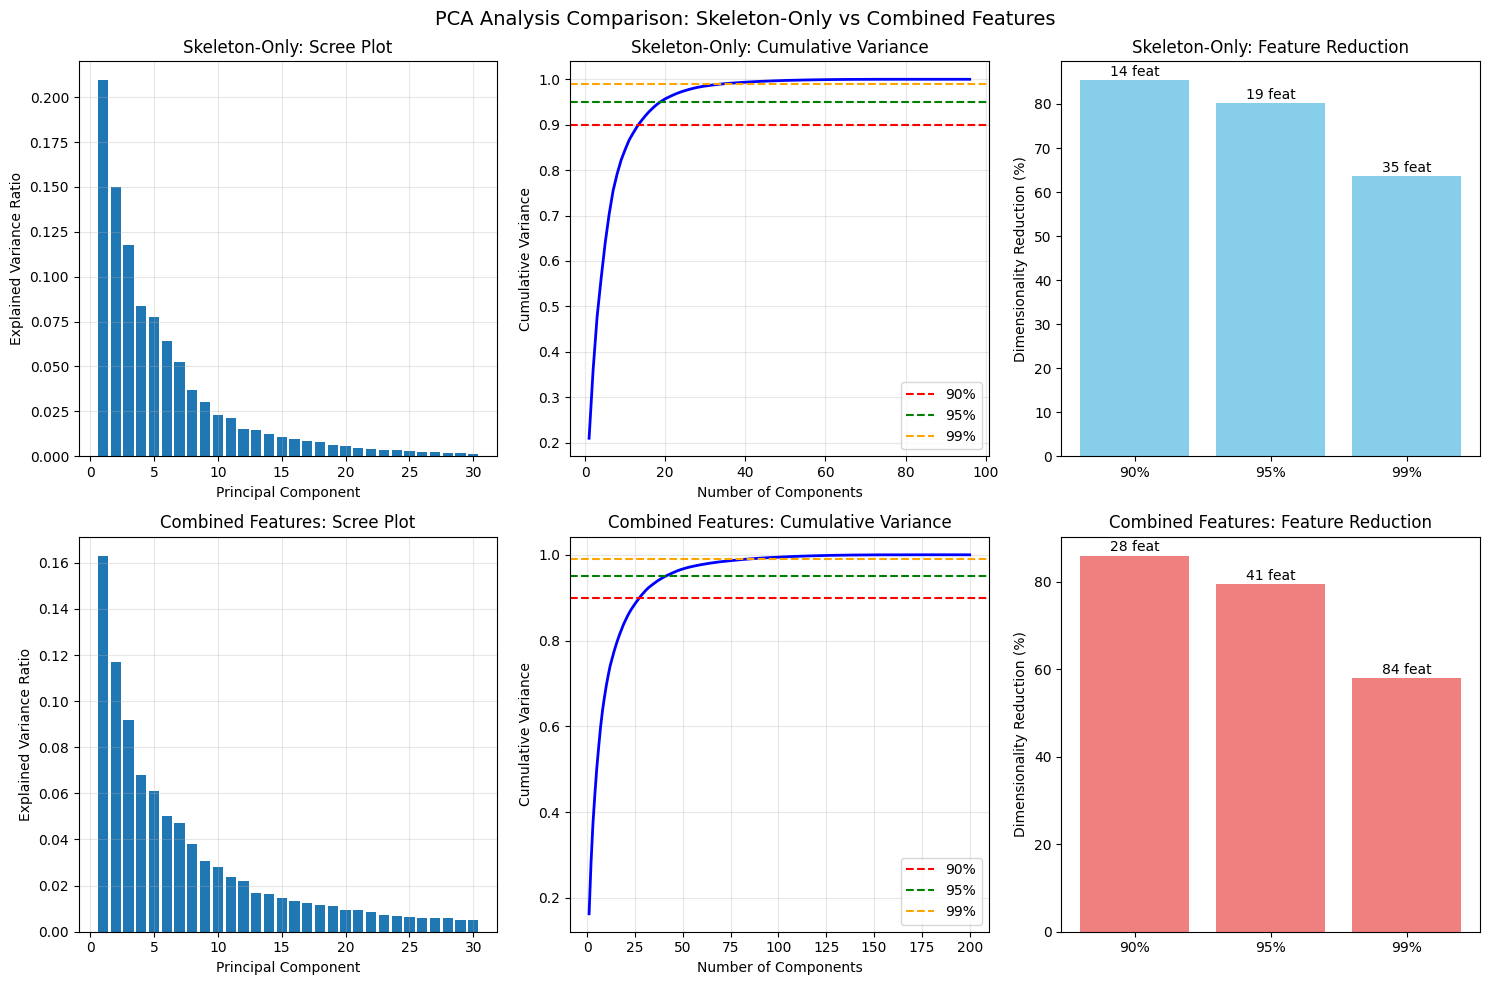

In [ ]:
# Visualize and compare both PCA analyses
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Skeleton-only PCA
# Scree plot
axes[0, 0].bar(range(1, 31), pca_results_skeleton['explained_variance_ratio'][:30])
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('Skeleton-Only: Scree Plot')
axes[0, 0].grid(True, alpha=0.3)

# Cumulative variance
axes[0, 1].plot(range(1, 97), pca_results_skeleton['cumulative_variance'], 'b-', linewidth=2)
axes[0, 1].axhline(y=0.90, color='r', linestyle='--', label='90%')
axes[0, 1].axhline(y=0.95, color='g', linestyle='--', label='95%')
axes[0, 1].axhline(y=0.99, color='orange', linestyle='--', label='99%')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Variance')
axes[0, 1].set_title('Skeleton-Only: Cumulative Variance')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Reduction comparison
var_levels = [0.90, 0.95, 0.99]
n_components_sk = [pca_results_skeleton[f'var_{v}']['n_components'] for v in var_levels]
reduction_sk = [(96 - n) / 96 * 100 for n in n_components_sk]
axes[0, 2].bar(range(len(var_levels)), reduction_sk, color='skyblue')
axes[0, 2].set_xticks(range(len(var_levels)))
axes[0, 2].set_xticklabels([f'{int(v*100)}%' for v in var_levels])
axes[0, 2].set_ylabel('Dimensionality Reduction (%)')
axes[0, 2].set_title('Skeleton-Only: Feature Reduction')
for i, (n, r) in enumerate(zip(n_components_sk, reduction_sk)):
    axes[0, 2].text(i, r + 1, f'{n} feat', ha='center')

# Row 2: Combined PCA
# Scree plot
axes[1, 0].bar(range(1, 31), pca_results_combined['explained_variance_ratio'][:30])
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Explained Variance Ratio')
axes[1, 0].set_title('Combined Features: Scree Plot')
axes[1, 0].grid(True, alpha=0.3)

# Cumulative variance
axes[1, 1].plot(range(1, min(201, len(pca_results_combined['cumulative_variance'])+1)),
                pca_results_combined['cumulative_variance'], 'b-', linewidth=2)
axes[1, 1].axhline(y=0.90, color='r', linestyle='--', label='90%')
axes[1, 1].axhline(y=0.95, color='g', linestyle='--', label='95%')
axes[1, 1].axhline(y=0.99, color='orange', linestyle='--', label='99%')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Cumulative Variance')
axes[1, 1].set_title('Combined Features: Cumulative Variance')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Reduction comparison
n_components_comb = [pca_results_combined[f'var_{v}']['n_components'] for v in var_levels]
reduction_comb = [(200 - n) / 200 * 100 for n in n_components_comb]
axes[1, 2].bar(range(len(var_levels)), reduction_comb, color='lightcoral')
axes[1, 2].set_xticks(range(len(var_levels)))
axes[1, 2].set_xticklabels([f'{int(v*100)}%' for v in var_levels])
axes[1, 2].set_ylabel('Dimensionality Reduction (%)')
axes[1, 2].set_title('Combined Features: Feature Reduction')
for i, (n, r) in enumerate(zip(n_components_comb, reduction_comb)):
    axes[1, 2].text(i, r + 1, f'{n} feat', ha='center')

plt.suptitle('PCA Analysis Comparison: Skeleton-Only vs Combined Features', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
def analyze_joint_importance_extended(pca_model, n_components=5, feature_type='skeleton'):
    """
    Analyze which joints/features contribute most to the top principal components.

    Args:
        pca_model: Fitted PCA model
        n_components: Number of components to analyze
        feature_type: 'skeleton' (96 features) or 'combined' (200 features)
    """
    loadings = pca_model.components_[:n_components, :]
    explained_var = pca_model.explained_variance_ratio_

    if feature_type == 'skeleton':
        # Map features to joints (32 joints × 3 coordinates = 96)
        joint_importance = np.zeros((n_components, 32))
        for comp_idx in range(n_components):
            for joint_idx in range(32):
                feature_indices = [joint_idx*3, joint_idx*3+1, joint_idx*3+2]
                joint_importance[comp_idx, joint_idx] = np.sum(np.abs(loadings[comp_idx, feature_indices]))

        # Find top joints for each component
        print(f"\nTop 5 Contributing Joints per Principal Component (Skeleton-Only):")
        print("="*60)
        for comp_idx in range(n_components):
            top_joints_idx = np.argsort(joint_importance[comp_idx, :])[-5:][::-1]
            print(f"\nPC{comp_idx+1} (explains {explained_var[comp_idx]*100:.1f}% variance):")
            for rank, joint_idx in enumerate(top_joints_idx, 1):
                joint_name = df_joints[df_joints['Joint Index'] == joint_idx].index[0]
                contribution = joint_importance[comp_idx, joint_idx]
                print(f"  {rank}. {joint_name}: {contribution:.3f}")

        return joint_importance

    elif feature_type == 'combined':
        # For combined features: 96 (skeleton) + 8 (angles) + 96 (velocities) = 200
        # Break down contributions by feature type
        skeleton_importance = np.zeros((n_components, 32))
        angle_importance = np.zeros((n_components, 8))
        velocity_importance = np.zeros((n_components, 32))

        for comp_idx in range(n_components):
            # Skeleton features (0-95)
            for joint_idx in range(32):
                feature_indices = [joint_idx*3, joint_idx*3+1, joint_idx*3+2]
                skeleton_importance[comp_idx, joint_idx] = np.sum(np.abs(loadings[comp_idx, feature_indices]))

            # Angle features (96-103)
            for angle_idx in range(8):
                angle_importance[comp_idx, angle_idx] = np.abs(loadings[comp_idx, 96 + angle_idx])

            # Velocity features (104-199)
            for joint_idx in range(32):
                vel_indices = [104 + joint_idx*3, 104 + joint_idx*3+1, 104 + joint_idx*3+2]
                velocity_importance[comp_idx, joint_idx] = np.sum(np.abs(loadings[comp_idx, vel_indices]))

        # Analyze contributions
        print(f"\nFeature Importance Analysis for Combined PCA:")
        print("="*70)

        angle_names = ['knee_L', 'knee_R', 'hip_L', 'hip_R',
                      'ankle_L', 'ankle_R', 'shoulder_L', 'shoulder_R']

        for comp_idx in range(n_components):
            print(f"\nPC{comp_idx+1} (explains {explained_var[comp_idx]*100:.1f}% variance):")

            # Overall contribution by feature type
            total_skel = np.sum(np.abs(loadings[comp_idx, :96]))
            total_angle = np.sum(np.abs(loadings[comp_idx, 96:104]))
            total_vel = np.sum(np.abs(loadings[comp_idx, 104:]))
            total_all = total_skel + total_angle + total_vel

            print(f"  Feature Type Contributions:")
            print(f"    Skeleton: {total_skel/total_all*100:.1f}%")
            print(f"    Angles:   {total_angle/total_all*100:.1f}%")
            print(f"    Velocity: {total_vel/total_all*100:.1f}%")

            # Top skeleton joints
            top_skel_idx = np.argsort(skeleton_importance[comp_idx, :])[-3:][::-1]
            print(f"  Top 3 Skeleton Joints:")
            for rank, joint_idx in enumerate(top_skel_idx, 1):
                joint_name = df_joints[df_joints['Joint Index'] == joint_idx].index[0]
                print(f"    {rank}. {joint_name}: {skeleton_importance[comp_idx, joint_idx]:.3f}")

            # Top angles
            top_angle_idx = np.argsort(angle_importance[comp_idx, :])[-3:][::-1]
            print(f"  Top 3 Angles:")
            for rank, angle_idx in enumerate(top_angle_idx, 1):
                print(f"    {rank}. {angle_names[angle_idx]}: {angle_importance[comp_idx, angle_idx]:.3f}")

            # Top velocity joints
            top_vel_idx = np.argsort(velocity_importance[comp_idx, :])[-3:][::-1]
            print(f"  Top 3 Velocity Joints:")
            for rank, joint_idx in enumerate(top_vel_idx, 1):
                joint_name = df_joints[df_joints['Joint Index'] == joint_idx].index[0]
                print(f"    {rank}. {joint_name}_vel: {velocity_importance[comp_idx, joint_idx]:.3f}")

        return skeleton_importance, angle_importance, velocity_importance

# Run analysis for skeleton-only PCA
print("\n" + "="*70)
print("SKELETON-ONLY PCA ANALYSIS")
print("="*70)
joint_importance_sk = analyze_joint_importance_extended(
    pca_results_skeleton['full_pca'],
    n_components=5,
    feature_type='skeleton'
)

# Run analysis for combined PCA
print("\n" + "="*70)
print("COMBINED FEATURES PCA ANALYSIS")
print("="*70)
skel_imp, angle_imp, vel_imp = analyze_joint_importance_extended(
    pca_results_combined['full_pca'],
    n_components=5,
    feature_type='combined'
)


SKELETON-ONLY PCA ANALYSIS

Top 5 Contributing Joints per Principal Component (Skeleton-Only):

PC1 (explains 20.9% variance):
  1. CLAVICLE_LEFT: 0.448
  2. SPINE_CHEST: 0.441
  3. NECK: 0.439
  4. SPINE_NAVAL: 0.429
  5. HEAD: 0.427

PC2 (explains 15.0% variance):
  1. CLAVICLE_RIGHT: 0.460
  2. NECK: 0.446
  3. HEAD: 0.440
  4. SPINE_CHEST: 0.420
  5. CLAVICLE_LEFT: 0.417

PC3 (explains 11.8% variance):
  1. ELBOW_LEFT: 0.315
  2. WRIST_RIGHT: 0.305
  3. WRIST_LEFT: 0.300
  4. HAND_RIGHT: 0.296
  5. THUMB_RIGHT: 0.290

PC4 (explains 8.4% variance):
  1. THUMB_LEFT: 0.414
  2. HAND_LEFT: 0.407
  3. WRIST_LEFT: 0.397
  4. HANDTIP_LEFT: 0.386
  5. ELBOW_LEFT: 0.341

PC5 (explains 7.7% variance):
  1. HAND_LEFT: 0.404
  2. EYE_LEFT: 0.394
  3. WRIST_LEFT: 0.394
  4. THUMB_LEFT: 0.375
  5. HANDTIP_LEFT: 0.373

COMBINED FEATURES PCA ANALYSIS

Feature Importance Analysis for Combined PCA:

PC1 (explains 16.3% variance):
  Feature Type Contributions:
    Skeleton: 93.7%
    Angles:   0.3%


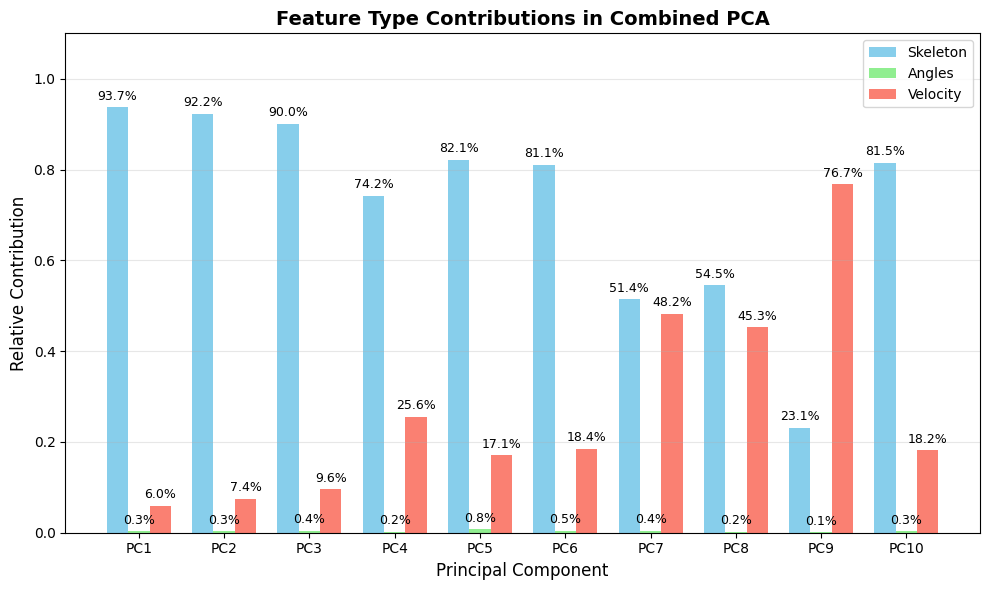

In [ ]:
# Feature type contribution breakdown for Combined PCA
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate feature contributions for each principal component
feature_contributions = []
for comp_idx in range(10):
    loadings = pca_results_combined['full_pca'].components_[comp_idx, :]
    total_skel = np.sum(np.abs(loadings[:96]))
    total_angle = np.sum(np.abs(loadings[96:104]))
    total_vel = np.sum(np.abs(loadings[104:]))
    total = total_skel + total_angle + total_vel
    feature_contributions.append([total_skel/total, total_angle/total, total_vel/total])

feature_contributions = np.array(feature_contributions)
x = np.arange(10)
width = 0.25

# Create grouped bar chart
bars1 = ax.bar(x - width, feature_contributions[:, 0], width, label='Skeleton', color='skyblue')
bars2 = ax.bar(x, feature_contributions[:, 1], width, label='Angles', color='lightgreen')
bars3 = ax.bar(x + width, feature_contributions[:, 2], width, label='Velocity', color='salmon')

# Add percentage labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height*100:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Relative Contribution', fontsize=12)
ax.set_title('Feature Type Contributions in Combined PCA', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'PC{i+1}' for i in range(10)])
ax.set_ylim(0, 1.1)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Autoencoder

In [ ]:
def build_seq2seq_autoencoder_paper(input_shape, latent_dim=50):
    """
    Builds a sequence-to-sequence autoencoder based on the paper by Jun et al.,
    with masking.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).
        latent_dim (int): The number of features in the compressed sequence.

    Returns:
        tuple: (autoencoder, encoder, decoder) Keras models.
    """
    # --- Encoder ---
    # 4-layer LSTM encoder
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    masked_input = layers.Masking(mask_value=0.0)(encoder_input)
    x = layers.LSTM(128, return_sequences=True)(masked_input)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    encoded_sequence = layers.TimeDistributed(
        layers.Dense(latent_dim, activation='tanh'),
        name='encoded_feature_sequence'
    )(x)
    encoder = Model(encoder_input, encoded_sequence, name='encoder')

    # --- Decoder ---
    # 1-layer LSTM decoder
    decoder_input = layers.Input(shape=(input_shape[0], latent_dim), name='decoder_input')

    # Add a Masking layer to make the decoder aware of padded steps
    masked_decoder_input = layers.Masking(mask_value=0.0)(decoder_input)

    # The single LSTM layer now takes the masked input
    x = layers.LSTM(128, return_sequences=True)(masked_decoder_input)

    decoded_sequence = layers.TimeDistributed(
        layers.Dense(input_shape[1], activation='linear'),
        name='decoded_output_sequence'
    )(x)
    decoder = Model(decoder_input, decoded_sequence, name='decoder')

    # --- Full Autoencoder ---
    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='seq2seq_autoencoder')

    return autoencoder, encoder, decoder

# Define configuration variables
MAX_TIMESTEPS = 268
INPUT_FEATURES = 96
LATENT_FEATURES_PER_STEP = 50 # The paper found 50 to be optimal

# Build the models
autoencoder, encoder, decoder = build_seq2seq_autoencoder_paper(
    input_shape=(MAX_TIMESTEPS, INPUT_FEATURES),
    latent_dim=LATENT_FEATURES_PER_STEP
)

# Print the model summaries to see the architecture
print("--- Full Autoencoder Summary ---")
autoencoder.summary()
print("\n--- Encoder Summary ---")
encoder.summary()
print("\n--- Decoder Summary ---")
decoder.summary()

--- Full Autoencoder Summary ---


Model: "seq2seq_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 268, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 268, 50)        │       332,466 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 268, 96)        │       104,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,498 (1.67 MB)

 Trainable params: 436,498 (1.67 MB)

 Non-trainable params: 0 (0.00 B)


--- Encoder Summary ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 268, 96)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, 268, 96)   │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_8 (Masking) │ (None, 268, 96)   │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_8 (Any)         │ (None, 268)       │          0 │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 268, 128)  │    115,200 │ masking_8[0][0],  │
│                     │                   │            │ any_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 268, 128)  │    131,584 │ lstm_25[0][0],    │
│                     │                   │            │ any_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 268, 64)   │     49,408 │ lstm_26[0][0],    │
│                     │                   │            │ any_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 268, 64)   │     33,024 │ lstm_27[0][0],    │
│                     │                   │            │ any_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoded_feature_se… │ (None, 268, 50)   │      3,250 │ lstm_28[0][0],    │
│ (TimeDistributed)   │                   │            │ any_8[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 332,466 (1.27 MB)

 Trainable params: 332,466 (1.27 MB)

 Non-trainable params: 0 (0.00 B)


--- Decoder Summary ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 268, 50)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_9         │ (None, 268, 50)   │          0 │ decoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_9 (Masking) │ (None, 268, 50)   │          0 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_9 (Any)         │ (None, 268)       │          0 │ not_equal_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 268, 128)  │     91,648 │ masking_9[0][0],  │
│                     │                   │            │ any_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoded_output_seq… │ (None, 268, 96)   │     12,384 │ lstm_29[0][0],    │
│ (TimeDistributed)   │                   │            │ any_9[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,032 (406.38 KB)

 Trainable params: 104,032 (406.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def masked_mse_loss(y_true, y_pred):
    """MSE loss that ignores padded values (zeros)."""
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    squared_error = tf.square(y_true - y_pred)
    masked_error = squared_error * mask
    return tf.reduce_sum(masked_error) / (tf.reduce_sum(mask) + 1e-8)

# Compile autoencoder
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=masked_mse_loss,
    metrics=['mae']
)

In [ ]:
# Callbacks for training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=CONFIG['PATIENCE'],
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

In [ ]:
def train_autoencoder_comparison(X_train_96, X_val_96, X_train_200, X_val_200, config):
    """Train autoencoders and save the encoder part of each model with performance tracking."""

    os.makedirs('saved_models', exist_ok=True)

    results = {}
    latent_dims = [20, 40, 60]

    for feature_set, X_train, X_val in [('96_features', X_train_96, X_val_96),
                                       ('200_features', X_train_200, X_val_200)]:

        print(f"\n{'='*70}")
        print(f"TRAINING AUTOENCODERS FOR {feature_set}")
        print(f"Input shape: {X_train.shape}")
        print('='*70)

        for latent_dim in latent_dims:
            print(f"\nTraining with latent_dim={latent_dim}...")

            autoencoder, encoder, decoder = build_seq2seq_autoencoder_paper(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                latent_dim=latent_dim
            )

            autoencoder.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=masked_mse_loss,
                metrics=['mae']
            )

            early_stop = EarlyStopping(monitor='val_loss', patience=config['PATIENCE'], restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

            # --- Start Performance Tracking ---
            start_time = time.time()
            process = psutil.Process()

            history = autoencoder.fit(
                X_train, X_train,
                batch_size=config['BATCH_SIZE'],
                epochs=config['EPOCHS'],
                validation_data=(X_val, X_val),
                callbacks=[early_stop, reduce_lr],
                verbose=1
            )

            # --- End Performance Tracking ---
            training_time = time.time() - start_time
            memory_usage = process.memory_info().rss / 1024 / 1024 # in MB

            val_loss = autoencoder.evaluate(X_val, X_val, verbose=0)[0]

            key = f"{feature_set}_latent{latent_dim}"
            save_path = f"saved_models/encoder_{key}.keras"
            encoder.save(save_path)

            results[key] = {
                'autoencoder': autoencoder,
                'encoder': encoder,
                'decoder': decoder,
                'history': history,
                'val_loss': val_loss,
                'latent_dim': latent_dim,
                'input_features': X_train.shape[2],
                'compression_ratio': X_train.shape[2] / latent_dim,
                'save_path': save_path,
                'training_time': training_time,
                'memory_usage': memory_usage
            }

            print(f"   Encoder saved to: {save_path}")
            print(f"   Val Loss: {val_loss:.6f} | Time: {training_time:.2f}s | Memory: {memory_usage:.2f} MB")

            # Clear memory for the next run in the loop
            tf.keras.backend.clear_session()
            gc.collect()

    return results

# Run training for both feature sets
ae_results = train_autoencoder_comparison(
    X_train_sk, X_val_sk,           # 96 features
    X_train_combined, X_val_combined, # 200 features
    CONFIG
)


TRAINING AUTOENCODERS FOR 96_features
Input shape: (960, 268, 96)

Training with latent_dim=20...
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 298ms/step - loss: 0.9496 - mae: 0.4335 - val_loss: 0.9497 - val_mae: 0.4636 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.7115 - mae: 0.3876 - val_loss: 0.8195 - val_mae: 0.4353 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.5565 - mae: 0.3583 - val_loss: 0.7357 - val_mae: 0.4215 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.4589 - mae: 0.3356 - val_loss: 0.6811 - val_mae: 0.4161 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.4185 - mae: 0.3273 - val_loss: 0.6271 - val_mae: 0.4036 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.3750 - mae: 0.3174 - val_loss: 0.5669 - val_mae: 0.3906 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/

In [ ]:
# Load
best_model_key = '200_features_latent60' # where to choose
model_path = ae_results[best_model_key]['save_path'] # load in /content/saved_models

# Load the saved encoder model from its file
print(f"\nLoading encoder from: {model_path}")
loaded_encoder = load_model(model_path)

# To extract features
print("Extracting features with the loaded encoder...")
latent_features = loaded_encoder.predict(X_train_combined)

print(f"Shape of extracted features: {latent_features.shape}")

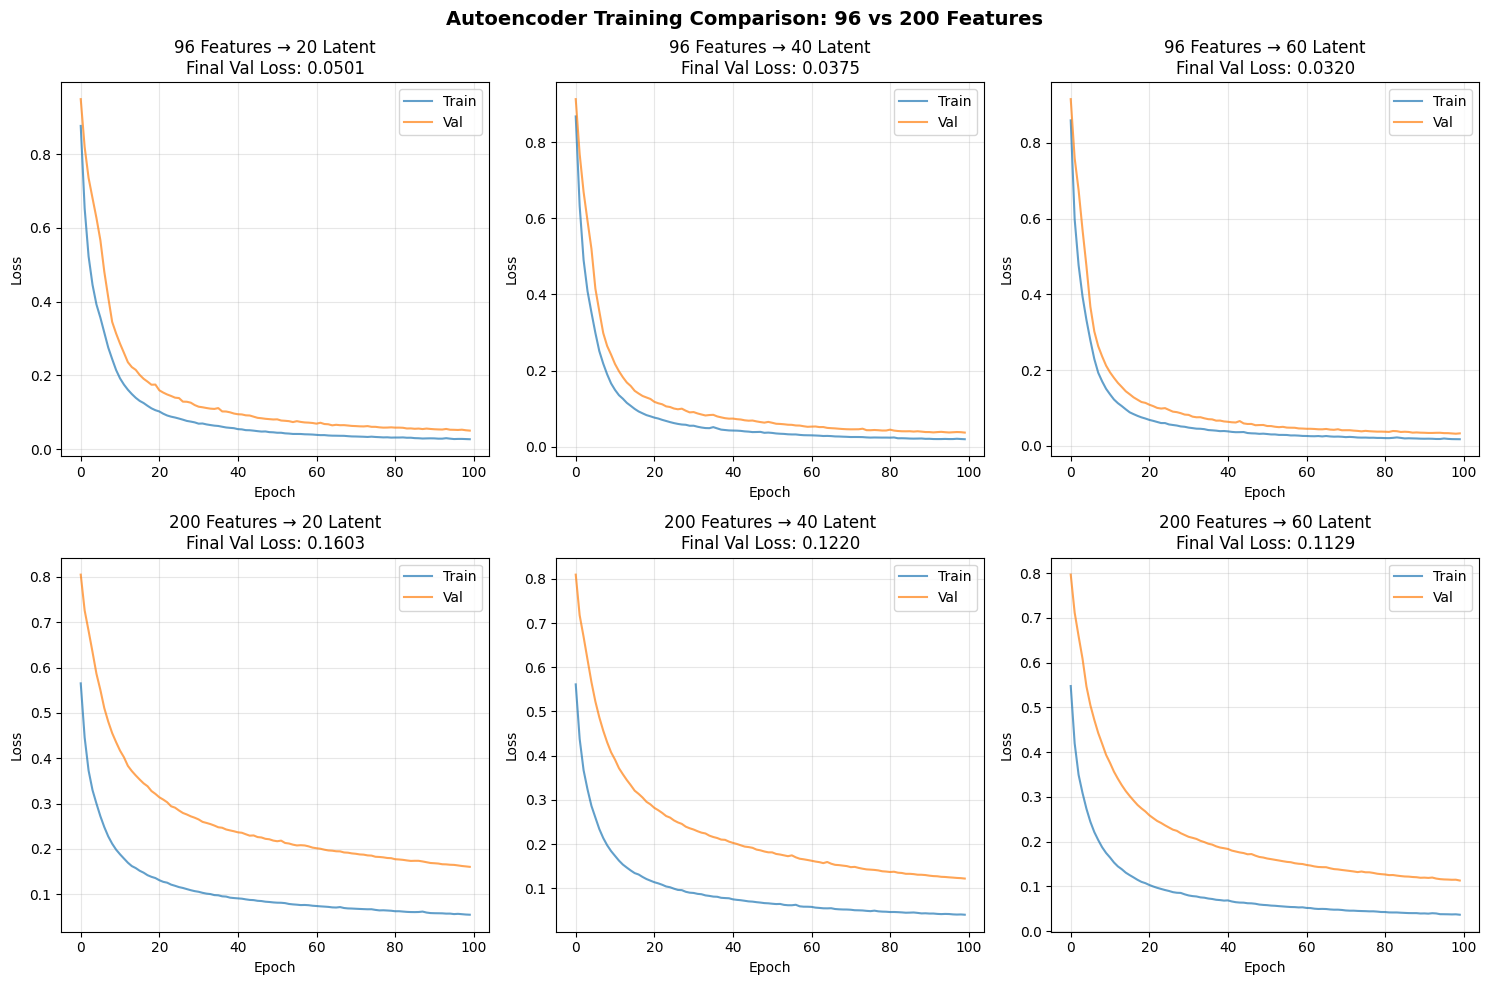

In [ ]:
# Visualize comparison of all autoencoders
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Organize results by feature set
results_96 = {k: v for k, v in ae_results.items() if '96_features' in k}
results_200 = {k: v for k, v in ae_results.items() if '200_features' in k}

# Row 1: 96 features
for idx, (key, res) in enumerate(results_96.items()):
    ax = axes[0, idx]

    # Plot training curves
    ax.plot(res['history'].history['loss'], label='Train', alpha=0.7)
    ax.plot(res['history'].history['val_loss'], label='Val', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f"96 Features → {res['latent_dim']} Latent\nFinal Val Loss: {res['val_loss']:.4f}")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Row 2: 200 features
for idx, (key, res) in enumerate(results_200.items()):
    ax = axes[1, idx]

    # Plot training curves
    ax.plot(res['history'].history['loss'], label='Train', alpha=0.7)
    ax.plot(res['history'].history['val_loss'], label='Val', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f"200 Features → {res['latent_dim']} Latent\nFinal Val Loss: {res['val_loss']:.4f}")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Autoencoder Training Comparison: 96 vs 200 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Create summary comparison
summary_data = []
for key, res in ae_results.items():
    summary_data.append({
        'Feature Set': '96 (Skeleton)' if '96_features' in key else '200 (Combined)',
        'Latent Dim': res['latent_dim'],
        'Compression Ratio': f"{res['compression_ratio']:.1f}x",
        'Val Loss': res['val_loss'],
        'Epochs Trained': len(res['history'].history['loss'])
    })

df_ae_summary = pd.DataFrame(summary_data)
df_ae_summary = df_ae_summary.sort_values(['Feature Set', 'Val Loss'])

print("\n" + "="*70)
print("AUTOENCODER COMPARISON SUMMARY")
print("="*70)
display(df_ae_summary)


AUTOENCODER COMPARISON SUMMARY


Feature Set  Latent Dim Compression Ratio  Val Loss  Epochs Trained
5  200 (Combined)          60              3.3x  0.112912             100
4  200 (Combined)          40              5.0x  0.121957             100
3  200 (Combined)          20             10.0x  0.160288             100
2   96 (Skeleton)          60              1.6x  0.031984             100
1   96 (Skeleton)          40              2.4x  0.037476             100
0   96 (Skeleton)          20              4.8x  0.050076             100

Testing PCA vs. Autoencoder on the 20 extracted features (from 96) via a simple Discriminative Model.

In [ ]:
# Selects the specific Autoencoder features (96-feature input, 20-dim output)
# Define the key
key_ae = '96_features_latent20'

if key_ae in ae_results:
    # Retrieves the specific trained encoder
    encoder_to_test = ae_results[key_ae]['encoder']

    # Generates the 20-dimensional latent features from the 96-feature input
    X_train_ae_20d = encoder_to_test.predict(X_train_sk)
    X_val_ae_20d = encoder_to_test.predict(X_val_sk)
    print(f"✓ Selected Autoencoder features with shape: {X_train_ae_20d.shape}")
else:
    raise ValueError(f"Could not find results for '{key_ae}'.")


# Prepare the PCA features (96-feature input, 20-dim output)
# Reshapes the 96-feature data for PCA
original_features = X_train_sk.shape[2]
X_train_reshaped = X_train_sk.reshape(-1, original_features)
X_val_reshaped = X_val_sk.reshape(-1, original_features)

# Fits PCA to get the top 20 components
pca = PCA(n_components=20)
pca.fit(X_train_reshaped)
print(f"PCA retaining {pca.n_components_} components.")

# Transforms the data
X_train_pca_20d_flat = pca.transform(X_train_reshaped)
X_val_pca_20d_flat = pca.transform(X_val_reshaped)

# Reshapes back to a sequence
X_train_pca_20d = X_train_pca_20d_flat.reshape(X_train_sk.shape[0], MAX_TIMESTEPS, 20)
X_val_pca_20d = X_val_pca_20d_flat.reshape(X_val_sk.shape[0], MAX_TIMESTEPS, 20)
print(f"✓ Selected PCA features with shape: {X_train_pca_20d.shape}")


# Build the Sequence Classifier Model
def build_sequence_classifier(input_shape, num_classes):
    """Builds a simple GRU classifier for sequence data."""
    model = Sequential([
        layers.Input(shape=input_shape, name='input_sequence'),
        layers.Masking(mask_value=0.0),
        layers.GRU(128, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

NUM_CLASSES = len(label_encoder.classes_)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Train and Evaluate on Autoencoder Features
print("\n--- Evaluating Autoencoder (20-dim) Features ---")
ae_classifier = build_sequence_classifier(input_shape=X_train_ae_20d.shape[1:], num_classes=NUM_CLASSES)
ae_classifier.fit(
    X_train_ae_20d, y_train,
    validation_data=(X_val_ae_20d, y_val),
    epochs=100, batch_size=32, callbacks=[early_stop], verbose=0
)
y_pred_ae = np.argmax(ae_classifier.predict(X_val_ae_20d), axis=1)
y_true = np.argmax(y_val, axis=1)
print("Classification Report for Autoencoder Features:")
print(classification_report(y_true, y_pred_ae, target_names=label_encoder.classes_, zero_division=0))


# Train and Evaluate on PCA Features
print("\n--- Evaluating PCA (20-dim) Features ---")
pca_classifier = build_sequence_classifier(input_shape=X_train_pca_20d.shape[1:], num_classes=NUM_CLASSES)
pca_classifier.fit(
    X_train_pca_20d, y_train,
    validation_data=(X_val_pca_20d, y_val),
    epochs=200, batch_size=32, callbacks=[early_stop], verbose=0
)
y_pred_pca = np.argmax(pca_classifier.predict(X_val_pca_20d), axis=1)
print("Classification Report for PCA Features:")
print(classification_report(y_true, y_pred_pca, target_names=label_encoder.classes_, zero_division=0))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
✓ Selected Autoencoder features with shape: (960, 268, 20)
PCA retaining 20 components.
✓ Selected PCA features with shape: (960, 268, 20)

--- Evaluating Autoencoder (20-dim) Features ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Classification Report for Autoencoder Features:
               precision    recall  f1-score   support

     antalgic       0.68      1.00      0.81        40
     lurching       1.00      0.97      0.99        40
       normal       0.83      0.95      0.88        40
     steppage       0.83      0.47      0.60        40
 stiff-legged       1.00      0.45      0.62        40
trendelenburg       0.73      1.00      0.84        40

     accuracy                           0.81       240
    macro avg       0.84      0.81      0.79       240
 weighted avg       0.84      0.81      0.79       240


--- Evaluating PCA (20-dim) Features ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Classification

# Dataset Definition

In [39]:
# Dataset Definition
def create_sequence_dataset(skeleton_data, gait_labels, batch_size, shuffle=True,
                           cache_file=None, validation=False):
    """
    Create TensorFlow dataset for sequence data

    Args:
        skeleton_data: numpy array of shape (N, T, F)
        gait_labels: one-hot encoded labels of shape (N, num_classes)
        batch_size: batch size for training
        shuffle: whether to shuffle the data
        cache_file: optional cache file path
        validation: if True, don't repeat the dataset
    """
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((skeleton_data, gait_labels))

    if cache_file:
        dataset = dataset.cache(cache_file)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(len(skeleton_data), 1000))

    # Only repeat for training, not for validation
    if not validation:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Models

In [41]:
# Model Definitions
class Models:
    # Quickly overfits, reaching 99% acc on train, but stops lower than 80% on test
    @staticmethod
    def baseline(input_shape, num_classes):
        return Sequential([
            layers.Input(shape=input_shape),
            layers.Masking(mask_value=0.),
            layers.LSTM(128),
            layers.Dropout(0.5),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

    # Tried reducing neurons first, then added regularization and heavy dropout,
    # training time is much longer,
    # but still overfits
    @staticmethod
    def baseline_regularized(input_shape, num_classes):
        l2_strength = 0.01  # Increased from 0.001
        return Sequential([
            layers.Input(shape=input_shape),
            layers.Masking(mask_value=0.),
            layers.LSTM(128,
                      kernel_regularizer=regularizers.l2(l2_strength),
                      recurrent_regularizer=regularizers.l2(l2_strength),
                      dropout=0.3,          # Add LSTM internal dropout
                      recurrent_dropout=0.3), # Add this
            layers.Dropout(0.6),  # Increased from 0.5
            layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
            layers.Dropout(0.6),  # Increased from 0.5
            layers.Dense(num_classes, activation='softmax')
        ])

    # Jumped from 67% test acc to 80% after setting PERC_MAX_TIMESTEPS to 0.7 instead of 0.95
    # Best model - extremely efficient, performs well on LOSO
    @staticmethod
    def gru(input_shape, num_classes):
        l2_strength = 0.01
        return Sequential([
            layers.Input(shape=input_shape),
            layers.Masking(mask_value=0.),
            layers.GRU(128, kernel_regularizer=regularizers.l2(l2_strength)),
            layers.Dropout(0.5),
            layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

    # Adding attention slighlty improves performance
    @staticmethod
    def attention(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = layers.Masking(mask_value=0.)(inputs)
        x = layers.LSTM(128, return_sequences=True)(x)
        x = layers.Dropout(0.3)(x)
        x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        return Model(inputs, outputs)

    # cite: [Jun20_1], Input: 100 frames instead of 50, all joints - 88% acc
    @staticmethod
    def deep_stacked_gru(input_shape, num_classes):
        """
        Deep 4-layer stacked GRU architecture as in Pathological
        Gait Classification Using Kinect v2 and Gated Recurrent Neural Networks"
        Architecture: ReLU → 4 stacked GRU layers → FC → Softmax
        """
        l2_strength = 0.01

        return Sequential([
            layers.Input(shape=input_shape),
            layers.Masking(mask_value=0.),

            # ReLU activation layer (applied to input features)
            layers.Dense(input_shape[-1], activation='relu'),

            # 4-layer stacked GRU structure (125 hidden neurons each)
            layers.GRU(125, return_sequences=True,
                      kernel_regularizer=regularizers.l2(l2_strength),
                      name='gru_layer_1'),

            layers.GRU(125, return_sequences=True,
                      kernel_regularizer=regularizers.l2(l2_strength),
                      name='gru_layer_2'),

            layers.GRU(125, return_sequences=True,
                      kernel_regularizer=regularizers.l2(l2_strength),
                      name='gru_layer_3'),

            layers.GRU(125, return_sequences=False,  # Last GRU outputs final hidden state
                      kernel_regularizer=regularizers.l2(l2_strength),
                      name='gru_layer_4'),

            # Fully Connected Layer (125 hidden neurons)
            layers.Dense(125, activation='relu',
                        kernel_regularizer=regularizers.l2(l2_strength),
                        name='fully_connected'),

            layers.Dropout(0.5),

            # Softmax Classifier (6 classes based on your data)
            layers.Dense(num_classes, activation='softmax', name='softmax_classifier')
        ])

    # Adding multi-head attention to the paper's architecture
    @staticmethod
    def deep_gru_attention(input_shape, num_classes):
        """Deep GRU with attention layer"""
        l2_strength = 0.01

        inputs = layers.Input(shape=input_shape)
        x = layers.Masking(mask_value=0.)(inputs)
        x = layers.Dense(input_shape[-1], activation='relu')(x)

        # Stacked GRUs
        x = layers.GRU(125, return_sequences=True, kernel_regularizer=regularizers.l2(l2_strength))(x)
        x = layers.GRU(125, return_sequences=True, kernel_regularizer=regularizers.l2(l2_strength))(x)
        x = layers.GRU(125, return_sequences=True, kernel_regularizer=regularizers.l2(l2_strength))(x)
        x = layers.GRU(125, return_sequences=True, kernel_regularizer=regularizers.l2(l2_strength))(x)

        # Attention mechanism
        attention = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = layers.Add()([x, attention])
        x = layers.GlobalAveragePooling1D()(x)

        x = layers.Dense(125, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)

        return Model(inputs, outputs)

    # CNN to automatically extract features,
    # timesteps is halved (50), and the original number of features (96) is transformed into 128 new features
    @staticmethod
    def cnn_lstm(input_shape, num_classes):
        return Sequential([
            layers.Input(shape=input_shape),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(2),
            layers.Dropout(0.3),
            layers.Masking(mask_value=0.),  # masking after CNN layers
            layers.LSTM(100, return_sequences=True),
            layers.LSTM(50),
            layers.Dropout(0.5),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    # Multimodal model
    @staticmethod
    def gru_cnn_fusion(input_shape_skeleton, input_shape_pressure, num_classes):
        """GRU for skeleton + CNN for pressure"""
        # Skeleton branch (GRU)
        skeleton_input = Input(shape=input_shape_skeleton)
        x_sk = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(skeleton_input)
        x_sk = BatchNormalization()(x_sk)
        x_sk = GRU(192, return_sequences=True, kernel_regularizer=regularizers.l2(1e-3))(x_sk)
        x_sk = BatchNormalization()(x_sk)
        x_sk = Dropout(0.4)(x_sk)
        x_sk = GRU(64, kernel_regularizer=regularizers.l2(1e-3))(x_sk)

        # Pressure branch (CNN)
        pressure_input = Input(shape=input_shape_pressure)
        x_pr = Conv1D(64, 3, activation='relu', padding='same')(pressure_input)
        x_pr = MaxPooling1D(2)(x_pr)
        x_pr = Conv1D(128, 3, activation='relu', padding='same')(x_pr)
        x_pr = MaxPooling1D(2)(x_pr)
        x_pr = GlobalAveragePooling1D()(x_pr)

        # Fusion
        x = Concatenate()([x_sk, x_pr])
        x = Dense(96, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax')(x)

        return Model([skeleton_input, pressure_input], outputs)

# Training

In [42]:
# tf.data.Dataset pipeline
def train_model_enhanced(model_func, model_name,
                         X_train, y_train,
                         X_val, y_val,
                         X_test, y_test,
                         config):
    """Enhanced training pipeline that uses the tf.data pipeline"""
    print(f"\n{'='*60}\nTraining Model: {model_name}")

    # Performance monitoring
    start_time = time.time()
    process = psutil.Process()

    # Build and compile the model
    model = model_func(X_train.shape[1:], y_train.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Create tf.data.Dataset pipelines
    train_dataset = create_sequence_dataset(
        X_train, y_train, # using manually pre-processed data
        config['BATCH_SIZE'],
        shuffle=True,
        validation=False
    )
    val_dataset = create_sequence_dataset(
        X_val, y_val, # manually pre-processed data
        config['BATCH_SIZE'],
        shuffle=False,
        validation=True
    )

    # Calculate steps per epoch
    steps_per_epoch = len(X_train) // config['BATCH_SIZE']
    validation_steps = len(X_val) // config['BATCH_SIZE']

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss',
                              patience=config['PATIENCE'],
                              restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # tf.data.Dataset objects
    history = model.fit(
        train_dataset,
        epochs=config['EPOCHS'],
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Evaluate on the final, unseen test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    # Performance metrics
    training_time = time.time() - start_time
    memory_usage = process.memory_info().rss / 1024 / 1024
    num_params = model.count_params()

    print(f"\n--- Results for {model_name} ---")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Memory Usage: {memory_usage:.2f} MB")
    print(f"Parameters: {num_params:,}")

    return {
        'model': model, 'history': history, 'test_loss': test_loss,
        'test_accuracy': test_acc, 'epochs': len(history.history['loss']),
        'training_time': training_time, 'memory_usage': memory_usage,
        'num_params': num_params
    }

In [95]:
# Train All Models
num_classes = y_train.shape[1]

models_to_test = {
    'Baseline': Models.baseline,
    'GRU': Models.gru,
    'Attention': Models.attention,
    'Deep Stacked GRU': Models.deep_stacked_gru,
    'Deep GRU + Attention': Models.deep_gru_attention,
    'CNN-LSTM': Models.cnn_lstm,
    # 'PCA-LSTM': Models.pca_lstm - removed
}

results = {}
for name, func in models_to_test.items():
    if name == 'PCA-LSTM':
        # Use the specialized training function for the PCA model
        results[name] = train_pca_model(
            func, name,
            X_train_sk, y_train,
            X_val_sk, y_val,
            X_test_sk, y_test,
            CONFIG, n_components=32 # Specify number of components
        )
    else:
        # Use the standard training function for all other models
        results[name] = train_model_enhanced(
            func, name,
            X_train_sk, y_train,
            X_val_sk, y_val,
            X_test_sk, y_test,
            CONFIG
        )

    # Clear memory after each model
    tf.keras.backend.clear_session()
    gc.collect()


Training Model: Baseline
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4246 - loss: 1.4202 - val_accuracy: 0.5446 - val_loss: 1.2424 - learning_rate: 0.0050
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8533 - loss: 0.4796 - val_accuracy: 0.8259 - val_loss: 0.6472 - learning_rate: 0.0050
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9124 - loss: 0.3776 - val_accuracy: 0.7366 - val_loss: 1.0178 - learning_rate: 0.0050
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9643 - loss: 0.1356 - val_accuracy: 0.8259 - val_loss: 0.7719 - learning_rate: 0.0050
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9739 - loss: 0.0905 - val_accuracy: 0.8393 - val_loss: 0.7363 - learning_rate: 0.0050
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9779 - loss: 0.0764 - val_accuracy: 0.7455 - val_loss: 0.9326 - learning_rate: 0.0050
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.93

In [46]:
# Find best model
best_model_name = max(results, key=lambda name: results[name]['test_accuracy'])
print(f"\n🏆 Best model: {best_model_name} with accuracy: {results[best_model_name]['test_accuracy']:.4f}")


🏆 Best model: GRU with accuracy: 0.8542


### Multimodal models

In [47]:
def create_multimodal_dataset(skeleton_data, pressure_data, gait_labels, batch_size,
                             shuffle=True, cache_file=None, validation=False):
    """
    Create TensorFlow dataset for multimodal data (skeleton + pressure)
    """
    # Create a Dataset object with two inputs
    dataset = tf.data.Dataset.from_tensor_slices(((skeleton_data, pressure_data), gait_labels))

    if cache_file:
        dataset = dataset.cache(cache_file)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(len(skeleton_data), 1000))

    if not validation:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [48]:
def train_multimodal_model(model_func, model_name,
                          X_train_sk, X_train_pr, y_train,
                          X_val_sk, X_val_pr, y_val,
                          X_test_sk, X_test_pr, y_test,
                          config):
    """Training pipeline for multimodal models"""
    print(f"\n{'='*60}\nTraining Multimodal Model: {model_name}")

    start_time = time.time()
    process = psutil.Process()

    # Build and compile the model - pass both input shapes
    model = model_func(X_train_sk.shape[1:], X_train_pr.shape[1:], y_train.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Create multimodal datasets
    train_dataset = create_multimodal_dataset(
        X_train_sk, X_train_pr, y_train,
        config['BATCH_SIZE'],
        shuffle=True,
        validation=False
    )
    val_dataset = create_multimodal_dataset(
        X_val_sk, X_val_pr, y_val,
        config['BATCH_SIZE'],
        shuffle=False,
        validation=True
    )

    # Calculate steps per epoch
    steps_per_epoch = len(X_train_sk) // config['BATCH_SIZE']
    validation_steps = len(X_val_sk) // config['BATCH_SIZE']

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=config['PATIENCE'], restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=config['EPOCHS'],
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Evaluate on test set - pass both inputs
    test_loss, test_acc = model.evaluate([X_test_sk, X_test_pr], y_test, verbose=0)

    # Performance metrics
    training_time = time.time() - start_time
    memory_usage = process.memory_info().rss / 1024 / 1024
    num_params = model.count_params()

    print(f"\n--- Results for {model_name} ---")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Memory Usage: {memory_usage:.2f} MB")
    print(f"Parameters: {num_params:,}")

    return {
        'model': model, 'history': history, 'test_loss': test_loss,
        'test_accuracy': test_acc, 'epochs': len(history.history['loss']),
        'training_time': training_time, 'memory_usage': memory_usage,
        'num_params': num_params
    }

In [49]:
# Train the multimodal model
result = train_multimodal_model(
    Models.gru_cnn_fusion,
    "gru_cnn_fusion",
    X_train_sk, X_train_pr, y_train,
    X_val_sk, X_val_pr, y_val,
    X_test_sk, X_test_pr, y_test,
    CONFIG
)


Training Multimodal Model: gru_cnn_fusion
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4094 - loss: 2.3628 - val_accuracy: 0.4554 - val_loss: 2.3233 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7897 - loss: 1.4858 - val_accuracy: 0.4598 - val_loss: 2.3076 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9367 - loss: 0.9680 - val_accuracy: 0.5446 - val_loss: 2.2930 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9785 - loss: 0.7630 - val_accuracy: 0.6027 - val_loss: 1.8322 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9820 - loss: 0.6599 - val_accuracy: 0.7589 - val_loss: 1.2758 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9909 - loss: 0.5831 - val_accuracy: 0.7232 - val_loss: 1.4007 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17m

# Validation

### K-Fold

In [59]:
def kfold_validation(model_func, X, y, subject_ids, config, model_name="Model"):
    """
    K-Fold cross-validation with time and memory tracking per fold.
    """
    print(f"{'='*60}\nGroup K-Fold Validation: {model_name}")

    group_kfold = GroupKFold(n_splits=config['K_FOLDS'])
    accuracies = []
    fold_times = []

    # Performance Tracking overall
    total_start_time = time.time()
    process = psutil.Process()

    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups=subject_ids), 1):
        print(f"\n--- Fold {fold}/{config['K_FOLDS']} ---")

        # Per-Fold Performance Tracking
        fold_start_time = time.time()

        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Build and compile model
        model = model_func(X.shape[1:], y.shape[1])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        model.fit(
            X_train_fold, y_train_fold,
            epochs=50,
            batch_size=32,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stop],
            verbose=0
        )

        _, acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracies.append(acc)

        # Report Per-Fold Metrics
        fold_end_time = time.time()
        fold_duration = fold_end_time - fold_start_time
        fold_times.append(fold_duration)
        # Get memory usage
        memory_usage = process.memory_info().rss / (1024 * 1024)

        print(f"  Fold {fold} Accuracy: {acc:.4f}")
        print(f"  Fold {fold} Duration: {fold_duration:.2f}s")
        print(f"  Current Memory Usage: {memory_usage:.2f} MB")

        # --- Clear Memory ---
        tf.keras.backend.clear_session()
        gc.collect()

    # Final Summary
    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_fold_time = np.mean(fold_times)

    print(f"\n{'='*20} Final Summary {'='*20}")
    print(f"Total K-Fold Execution Time: {total_duration:.2f}s")
    print(f"Average Time per Fold: {avg_fold_time:.2f}s")
    print(f"\nMean Group K-Fold Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

    return mean_acc, std_acc, accuracies

In [60]:
# Data Pooling for Validation

# Combine the processed NumPy arrays from the train and validation sets
# np.concatenate for arrays
print("Creating a data pool for cross-validation from processed train/val tensors...")
X_cv_tensor = np.concatenate([X_train_sk, X_val_sk], axis=0)
y_cv_pool = np.concatenate([y_train, y_val], axis=0)
print(f"Cross-validation tensor created with shape: {X_cv_tensor.shape}")

Creating a data pool for cross-validation from processed train/val tensors...
Cross-validation tensor created with shape: (1200, 100, 96)


In [61]:
kfold_results = {}
# 'best_model_name' is defined from earlier training run
model_func = models_to_test[best_model_name]

# subject ID array for val pool
subject_ids_cv_pool = df_manifest[df_manifest['subject_id'].isin(np.concatenate([train_subjects, val_subjects]))]['subject_id'].values

# Run
mean_acc, std_acc, fold_accs = kfold_validation(
    model_func,
    X_cv_tensor,
    y_cv_pool,
    subject_ids_cv_pool, # passes the subject IDs here
    CONFIG,
    best_model_name
)
kfold_results[best_model_name] = {'mean': mean_acc, 'std': std_acc, 'folds': fold_accs}

Group K-Fold Validation: GRU

--- Fold 1/5 ---
  Fold 1 Accuracy: 0.9542
  Fold 1 Duration: 17.55s
  Current Memory Usage: 4174.09 MB

--- Fold 2/5 ---
  Fold 2 Accuracy: 0.9208
  Fold 2 Duration: 18.58s
  Current Memory Usage: 4185.90 MB

--- Fold 3/5 ---
  Fold 3 Accuracy: 0.9667
  Fold 3 Duration: 18.36s
  Current Memory Usage: 4194.64 MB

--- Fold 4/5 ---
  Fold 4 Accuracy: 0.9083
  Fold 4 Duration: 11.57s
  Current Memory Usage: 4205.15 MB

--- Fold 5/5 ---
  Fold 5 Accuracy: 0.8708
  Fold 5 Duration: 15.94s
  Current Memory Usage: 4215.79 MB

==================== Final Summary ====================
Total K-Fold Execution Time: 89.12s
Average Time per Fold: 16.40s

Mean Group K-Fold Accuracy: 0.9242 ± 0.0341


### LOSO

In [85]:
def loso_validation(model_func, X, y, subject_ids, config, model_name="Model"):
    """
    Leave-One-Subject-Out (LOSO) cross-validation with detailed time and memory tracking.
    """
    print(f"{'='*60}\nLOSO Validation: {model_name}")

    unique_subjects = np.unique(subject_ids)
    accuracies = []
    fold_times = []

    # Total Performance Tracking
    total_start_time = time.time()
    process = psutil.Process()

    for i, test_subject in enumerate(unique_subjects, 1):
        print(f"\n--- Fold {i}/{len(unique_subjects)} | Testing on Subject: {test_subject} ---")

        # Per-Fold Performance Tracking
        fold_start_time = time.time()

        # Create data splits for the current fold
        train_val_subjects = [s for s in unique_subjects if s != test_subject]
        random.shuffle(train_val_subjects)
        validation_subject = train_val_subjects.pop()
        train_subjects = train_val_subjects

        print(f"  Validating on Subject: {validation_subject}")

        train_mask = np.isin(subject_ids, train_subjects)
        val_mask = subject_ids == validation_subject
        test_mask = subject_ids == test_subject

        X_train_fold, y_train_fold = X[train_mask], y[train_mask]
        X_val_fold, y_val_fold = X[val_mask], y[val_mask]
        X_test_fold, y_test_fold = X[test_mask], y[test_mask]

        # Build and compile model
        model = model_func(X.shape[1:], y.shape[1])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        # Fit the model
        model.fit(
            X_train_fold, y_train_fold,
            epochs=50,
            batch_size=32,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stop],
            verbose=0
        )

        _, acc = model.evaluate(X_test_fold, y_test_fold, verbose=0)
        accuracies.append(acc)

        # Report Per-Fold Metrics
        fold_end_time = time.time()
        fold_duration = fold_end_time - fold_start_time
        fold_times.append(fold_duration)
        memory_usage = process.memory_info().rss / (1024 * 1024)

        print(f"  Accuracy: {acc:.4f}")
        print(f"  Fold Duration: {fold_duration:.2f}s")
        print(f"  Current Memory Usage: {memory_usage:.2f} MB")

        # --- Clear Memory ---
        tf.keras.backend.clear_session()
        gc.collect()

    # Final Summary
    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_fold_time = np.mean(fold_times)

    print(f"\n{'='*20} Final Summary {'='*20}")
    print(f"Total LOSO Execution Time: {total_duration:.2f}s")
    print(f"Average Time per Fold: {avg_fold_time:.2f}s")
    print(f"\nMean LOSO Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

    return mean_acc, std_acc, accuracies

In [87]:
loso_results = {}
model_func = models_to_test[best_model_name]

mean_acc, std_acc, fold_accs = loso_validation(
    model_func,
    X_cv_tensor,
    y_cv_pool,
    subject_ids_cv_pool,
    CONFIG,
    best_model_name
)
loso_results[best_model_name] = {'mean': mean_acc, 'std': std_acc, 'folds': fold_accs}

LOSO Validation: GRU

--- Fold 1/10 | Testing on Subject: 1 ---
  Validating on Subject: 4
  Accuracy: 1.0000
  Fold Duration: 17.81s
  Current Memory Usage: 5416.26 MB

--- Fold 2/10 | Testing on Subject: 2 ---
  Validating on Subject: 11
  Accuracy: 0.9500
  Fold Duration: 17.89s
  Current Memory Usage: 5366.84 MB

--- Fold 3/10 | Testing on Subject: 3 ---
  Validating on Subject: 11
  Accuracy: 0.8750
  Fold Duration: 14.92s
  Current Memory Usage: 5375.27 MB

--- Fold 4/10 | Testing on Subject: 4 ---
  Validating on Subject: 7
  Accuracy: 0.7750
  Fold Duration: 16.56s
  Current Memory Usage: 5382.30 MB

--- Fold 5/10 | Testing on Subject: 5 ---
  Validating on Subject: 11
  Accuracy: 0.7917
  Fold Duration: 17.72s
  Current Memory Usage: 5389.23 MB

--- Fold 6/10 | Testing on Subject: 7 ---
  Validating on Subject: 11
  Accuracy: 0.6667
  Fold Duration: 17.16s
  Current Memory Usage: 5401.26 MB

--- Fold 7/10 | Testing on Subject: 8 ---
  Validating on Subject: 2
  Accuracy: 0.800

# Evaluation

In [96]:
# Results Summary
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

# Create results dataframe
df_results = pd.DataFrame([{
    'Model': name,
    'Test Accuracy': r['test_accuracy'],
    'Test Loss': r['test_loss'],
    'Epochs': r['epochs'],
    'Time (s)': r['training_time'],
    'Memory (MB)': r['memory_usage'],
    'Parameters': r['num_params']
} for name, r in results.items()]).sort_values('Test Accuracy', ascending=False)

print("\nModel Performance Comparison:")
print(df_results.to_string(index=False))

# Best model detailed analysis
best_results = results[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"    Test Accuracy: {best_results['test_accuracy']:.4f}")
print(f"    K-Fold CV: {kfold_results[best_model_name]['mean']:.4f} ± {kfold_results[best_model_name]['std']:.4f}")
print(f"    LOSO CV: {loso_results[best_model_name]['mean']:.4f} ± {loso_results[best_model_name]['std']:.4f}")

# Generate predictions for confusion matrix
y_pred = np.argmax(best_results['model'].predict(X_test_sk, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report[['precision', 'recall', 'f1-score', 'support']].round(3))

# Save results
df_results.to_csv(f'model_comparison_results.csv', index=False)
df_report.to_csv(f'{best_model_name}_classification_report.csv')




FINAL RESULTS SUMMARY

Model Performance Comparison:
               Model  Test Accuracy  Test Loss  Epochs  Time (s)  Memory (MB)  Parameters
                 GRU       0.891667   0.922110      34 11.917838  5486.320312       95430
           Attention       0.800000   3.479320      16  9.679888  5538.578125      189894
            Baseline       0.758333   1.325642      12  5.856998  5530.273438      123846
    Deep Stacked GRU       0.758333   1.496761      23 20.557041  5586.488281      392943
            CNN-LSTM       0.708333   1.318335      12  8.516166  5690.437500      168654
Deep GRU + Attention       0.512500   1.821978      47 41.072966  5662.253906      457452

🏆 Best Model: GRU
    Test Accuracy: 0.8917
    K-Fold CV: 0.9242 ± 0.0341
    LOSO CV: 0.8733 ± 0.1044

Classification Report:
               precision  recall  f1-score  support
antalgic           0.661   0.975     0.788   40.000
lurching           0.930   1.000     0.964   40.000
normal             0.975   0.97

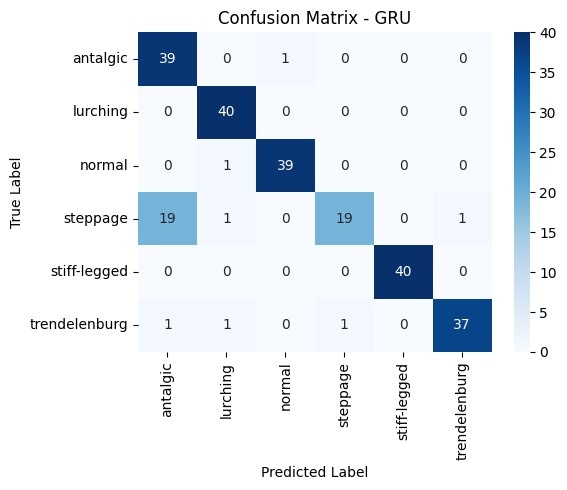

In [127]:
# Confusion matrix visualization
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [128]:
# Create feature names using your existing df_joints
feature_names = []
for joint_idx in range(len(df_joints)):
    joint_name = df_joints.iloc[joint_idx].name  # Gets the joint name (index of df_joints)
    feature_names.extend([f"{joint_name}_X", f"{joint_name}_Y", f"{joint_name}_Z"])

# Feature Analysis for Steppage vs Confused Classes
print("FEATURE-LEVEL ANALYSIS")

# Identify main confusion pairs
antalgic_idx = list(label_encoder.classes_).index('antalgic')
trendelenburg_idx = list(label_encoder.classes_).index('trendelenburg')

# Get samples for each class
steppage_idx = list(label_encoder.classes_).index('steppage')
steppage_samples = X_test_sk[y_true == steppage_idx]
antalgic_samples = X_test_sk[y_true == antalgic_idx]
trendelenburg_samples = X_test_sk[y_true == trendelenburg_idx]

def compare_gait_patterns(samples1, samples2, name1, name2):
    """Compare statistical properties of two gait patterns"""
    # Calculate mean and std across time for each feature
    mean1 = np.mean(samples1, axis=(0, 1))  # Mean across samples and time
    mean2 = np.mean(samples2, axis=(0, 1))
    std1 = np.std(samples1, axis=(0, 1))
    std2 = np.std(samples2, axis=(0, 1))

    # Calculate feature-wise differences
    mean_diff = np.abs(mean1 - mean2)

    # Find most different features
    top_diff_indices = np.argsort(mean_diff)[-10:]  # Top 10 most different features

    print(f"\n{'='*100}")
    print(f"{name1} vs {name2} - Top 10 Differentiating Features")
    print(f"{'='*100}")

    # Create a formatted table
    comparison_data = []
    for idx in reversed(top_diff_indices):
        # Get feature name using the feature_names list
        feature_name = feature_names[idx] if idx < len(feature_names) else f'F{idx:02d}'

        comparison_data.append({
            'Feature': feature_name,
            f'{name1} Mean': f'{mean1[idx]:.3f}',
            f'{name1} Std': f'{std1[idx]:.3f}',
            f'{name2} Mean': f'{mean2[idx]:.3f}',
            f'{name2} Std': f'{std2[idx]:.3f}',
            'Diff': f'{mean_diff[idx]:.3f}'
        })

    # Convert to DataFrame for nice printing
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))
    print()  # Add extra spacing

    return mean_diff

# Compare steppage with commonly confused classes
diff_antalgic = compare_gait_patterns(steppage_samples, antalgic_samples, 'Steppage', 'Antalgic')
diff_trendelenburg = compare_gait_patterns(steppage_samples, trendelenburg_samples, 'Steppage', 'Trendelenburg')

FEATURE-LEVEL ANALYSIS

Steppage vs Antalgic - Top 10 Differentiating Features
        Feature Steppage Mean Steppage Std Antalgic Mean Antalgic Std  Diff
    KNEE_LEFT_Z         0.671        2.129        -0.110        0.523 0.780
   KNEE_RIGHT_Y         0.654        1.149        -0.024        0.729 0.678
   ELBOW_LEFT_Y         0.074        1.084         0.720        0.900 0.645
SHOULDER_LEFT_Y         0.106        0.864         0.730        0.392 0.624
  SPINE_NAVAL_Y         0.107        0.963         0.727        0.523 0.620
    HIP_RIGHT_Z         0.159        0.908         0.712        0.748 0.553
     HIP_LEFT_Z        -0.159        0.908        -0.712        0.748 0.553
  SPINE_CHEST_Y         0.143        1.000         0.694        0.612 0.551
CLAVICLE_LEFT_Y         0.274        0.960         0.812        0.545 0.538
    KNEE_LEFT_Y         0.736        1.330         0.232        0.867 0.503


Steppage vs Trendelenburg - Top 10 Differentiating Features
      Feature Steppage 

TEMPORAL PATTERN ANALYSIS

Steppage Temporal Characteristics:
  Mean temporal variance: 0.5274
  Temporal smoothness (lower=smoother): 0.1157
  Most variable features:
    - KNEE_LEFT_Z: variance = 3.7578
    - ANKLE_LEFT_Z: variance = 1.6566
    - KNEE_LEFT_Y: variance = 1.5373
    - HANDTIP_LEFT_Y: variance = 1.2945
    - HAND_LEFT_Y: variance = 1.2372

Antalgic Temporal Characteristics:
  Mean temporal variance: 0.3784
  Temporal smoothness (lower=smoother): 0.0987
  Most variable features:
    - HANDTIP_LEFT_Y: variance = 1.8053
    - THUMB_LEFT_Y: variance = 1.7271
    - HAND_LEFT_Y: variance = 1.6810
    - WRIST_LEFT_Y: variance = 1.3206
    - FOOT_LEFT_Y: variance = 0.9377

Trendelenburg Temporal Characteristics:
  Mean temporal variance: 0.5147
  Temporal smoothness (lower=smoother): 0.1060
  Most variable features:
    - SPINE_NAVAL_X: variance = 1.7151
    - SPINE_CHEST_X: variance = 1.6732
    - NECK_X: variance = 1.5799
    - HEAD_X: variance = 1.5483
    - CLAVICLE_LEFT_X:

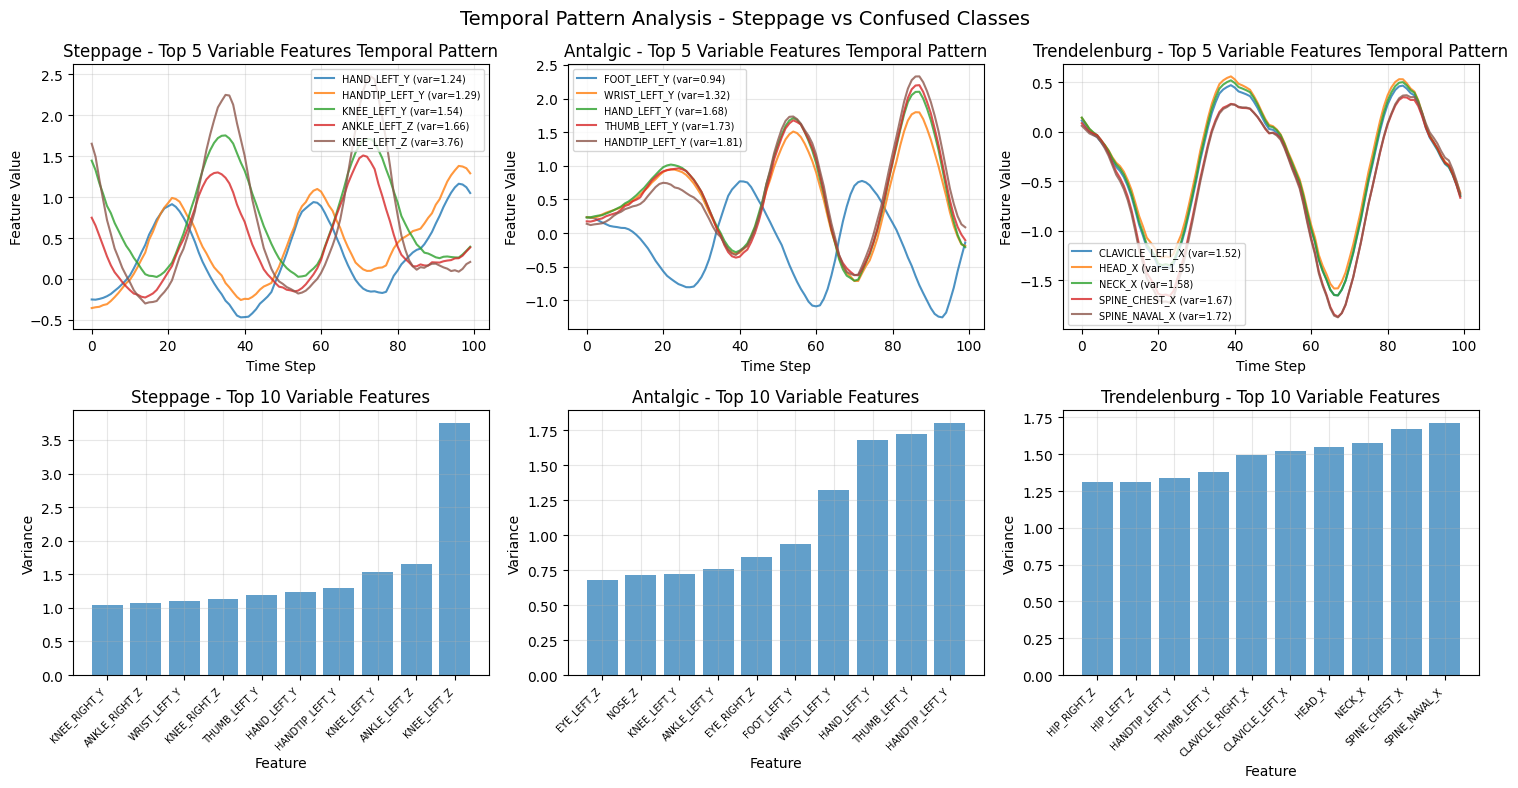

In [126]:
# Temporal Pattern Analysis
print("TEMPORAL PATTERN ANALYSIS")

# Analyze temporal dynamics
def analyze_temporal_patterns(X_class, class_name):
    """Analyze temporal characteristics of a gait pattern"""
    # Calculate variance over time for each sample
    temporal_variance = np.var(X_class, axis=1)  # Shape: (n_samples, n_features)
    mean_temporal_var = np.mean(temporal_variance, axis=0)

    # Calculate autocorrelation-like measure
    diff = np.diff(X_class, axis=1)  # Temporal differences
    temporal_smoothness = np.mean(np.abs(diff), axis=(0, 1))

    print(f"\n{class_name} Temporal Characteristics:")
    print(f"  Mean temporal variance: {np.mean(mean_temporal_var):.4f}")
    print(f"  Temporal smoothness (lower=smoother): {np.mean(temporal_smoothness):.4f}")

    # Find most variable features over time with names
    top_var_features = np.argsort(mean_temporal_var)[-5:]
    print(f"  Most variable features:")
    for feat_idx in reversed(top_var_features):
        feat_name = feature_names[feat_idx] if feat_idx < len(feature_names) else f'F{feat_idx:02d}'
        print(f"    - {feat_name}: variance = {mean_temporal_var[feat_idx]:.4f}")

    return mean_temporal_var, temporal_smoothness

# Analyze each class - THIS CREATES THE MISSING VARIABLES
steppage_var, steppage_smooth = analyze_temporal_patterns(steppage_samples, 'Steppage')
antalgic_var, antalgic_smooth = analyze_temporal_patterns(antalgic_samples, 'Antalgic')
trend_var, trend_smooth = analyze_temporal_patterns(trendelenburg_samples, 'Trendelenburg')

# Visualize temporal patterns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot average temporal patterns for key features
for idx, (samples, name) in enumerate([(steppage_samples, 'Steppage'),
                                        (antalgic_samples, 'Antalgic'),
                                        (trendelenburg_samples, 'Trendelenburg')]):
    # Select a few representative features
    mean_pattern = np.mean(samples, axis=0)  # Average across samples

    # Get the variance for each feature
    if name == 'Steppage':
        var_data = steppage_var
    elif name == 'Antalgic':
        var_data = antalgic_var
    else:
        var_data = trend_var

    # Get the 5 most variable features
    top_5_var_indices = np.argsort(var_data)[-5:]

    # Plot top 5 most variable features over time
    ax = axes[0, idx]

    # Use distinct colors
    colors = plt.cm.tab10(np.linspace(0, 0.5, 5))

    for i, feat in enumerate(top_5_var_indices):
        feat_name = feature_names[feat] if feat < len(feature_names) else f'F{feat:02d}'
        ax.plot(mean_pattern[:, feat],
                alpha=0.8,
                label=f'{feat_name} (var={var_data[feat]:.2f})',
                linewidth=1.5,
                color=colors[i])

    ax.set_title(f'{name} - Top 5 Variable Features Temporal Pattern')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Feature Value')
    ax.legend(fontsize=7, loc='best')
    ax.grid(alpha=0.3)

    # Plot feature variance with names on x-axis
    ax = axes[1, idx]

    # Plot top 10 most variable features
    top_var_indices = np.argsort(var_data)[-10:]
    feature_labels = [feature_names[i] if i < len(feature_names) else f'F{i:02d}'
                     for i in top_var_indices]

    ax.bar(range(len(top_var_indices)), var_data[top_var_indices], alpha=0.7)
    ax.set_title(f'{name} - Top 10 Variable Features')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Variance')
    ax.set_xticks(range(len(top_var_indices)))
    ax.set_xticklabels(feature_labels, rotation=45, ha='right', fontsize=7)
    ax.grid(alpha=0.3)

plt.suptitle('Temporal Pattern Analysis - Steppage vs Confused Classes', fontsize=14)
plt.tight_layout()
plt.show()

# Training on 200 features (96 original skeleton data + engineered angles and velocities)

In [66]:
# Pipeline for training on engineered features

models_to_test = {
    'Baseline': Models.baseline,
    'GRU': Models.gru,
    'Attention': Models.attention,
    'Deep Stacked GRU': Models.deep_stacked_gru,
    'Deep GRU + Attention': Models.deep_gru_attention,
    'CNN-LSTM': Models.cnn_lstm
}

# Create a new dictionary to store the results for this pipeline
results_combined = {}

for name, func in models_to_test.items():
    # We now pass your pre-combined data directly into the training function.
    # The labels (y_train, y_val, y_test) are the same for both pipelines.
    results_combined[name] = train_model_enhanced(
        model_func=func,
        model_name=f"{name} (Combined Features)",
        X_train=X_train_combined,
        y_train=y_train,
        X_val=X_val_combined,
        y_val=y_val,
        X_test=X_test_combined,
        y_test=y_test,
        config=CONFIG
    )
    # Clear memory after each model run
    tf.keras.backend.clear_session()
    gc.collect()


Training Model: Baseline (Combined Features)
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4468 - loss: 1.4382 - val_accuracy: 0.6205 - val_loss: 1.1666 - learning_rate: 0.0050
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8401 - loss: 0.4980 - val_accuracy: 0.7232 - val_loss: 1.0484 - learning_rate: 0.0050
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9227 - loss: 0.2276 - val_accuracy: 0.6696 - val_loss: 1.4034 - learning_rate: 0.0050
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9115 - loss: 0.2660 - val_accuracy: 0.7902 - val_loss: 0.8334 - learning_rate: 0.0050
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9568 - loss: 0.1696 - val_accuracy: 0.7545 - val_loss: 1.5479 - learning_rate: 0.0050
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9560 - loss: 0.1459 - val_accuracy: 0.7634 - val_loss: 1.4627 - learning_rate: 0.0050
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

# SSN

In [222]:
!pip install snntorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.9 MB/s eta 0:00:00


In [243]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import LeaveOneGroupOut
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [251]:
# --- Hyperparameters ---
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_EPOCHS = 100

# SNN-specific parameters
BETA = 0.9  # Neuron leak rate
THRESHOLD = 1.0 # Neuron firing threshold

# Define the surrogate gradient function
spike_grad = surrogate.fast_sigmoid(slope=75)

In [245]:
# Deep Recurrent SNN Model (Comparable to the 4-layer GRU)
class DeepSNNGait(nn.Module):
    """A deep, 4-layer recurrent SNN analogous to the deep_stacked_gru."""
    def __init__(self, timesteps: int, in_features: int, hidden_size: int, n_classes: int,
                 surr_grad, learn_thr=False, thr=1.0, beta=0.9):
        super().__init__()
        self.timesteps = timesteps
        self.in_features = in_features

        # 1. Initial Input Layer (like the first Dense layer in the GRU model)
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.lif_in = snn.Leaky(beta=beta, threshold=thr, spike_grad=surr_grad)

        # 2. Four Stacked Recurrent Hidden Layers (like the 4 GRU layers)
        self.rlif1 = snn.RLeaky(beta=beta, threshold=thr, linear_features=hidden_size, spike_grad=surr_grad)
        self.rlif2 = snn.RLeaky(beta=beta, threshold=thr, linear_features=hidden_size, spike_grad=surr_grad)
        self.rlif3 = snn.RLeaky(beta=beta, threshold=thr, linear_features=hidden_size, spike_grad=surr_grad)
        self.rlif4 = snn.RLeaky(beta=beta, threshold=thr, linear_features=hidden_size, spike_grad=surr_grad)

        # 3. Fully Connected Readout Layer (like the second Dense layer)
        self.fc_readout = nn.Linear(hidden_size, hidden_size)
        self.lif_readout = snn.Leaky(beta=beta, threshold=thr, spike_grad=surr_grad)
        self.dropout = nn.Dropout(0.5)

        # 4. Final Output Classifier Layer
        self.fc_out = nn.Linear(hidden_size, n_classes)
        self.lif_out = snn.Leaky(beta=beta, threshold=thr, spike_grad=surr_grad)

    def forward(self, x):
        # Initialize all hidden states
        mem_in = self.lif_in.init_leaky()
        spk_r1, mem_r1 = self.rlif1.init_rleaky()
        spk_r2, mem_r2 = self.rlif2.init_rleaky()
        spk_r3, mem_r3 = self.rlif3.init_rleaky()
        spk_r4, mem_r4 = self.rlif4.init_rleaky()
        mem_readout = self.lif_readout.init_leaky()
        mem_out = self.lif_out.init_leaky()

        # Lists to record the final layer's output over time
        spk_out_rec = []
        mem_out_rec = []

        # Time-step loop
        for t in range(self.timesteps):
            xt = x[:, t, :]

            # Pass through layers sequentially for the current time step
            h_in = self.fc_in(xt)
            spk_in, mem_in = self.lif_in(h_in, mem_in)

            # Stacked recurrent layers
            spk_r1, mem_r1 = self.rlif1(spk_in, spk_r1, mem_r1)
            spk_r2, mem_r2 = self.rlif2(spk_r1, spk_r2, mem_r2)
            spk_r3, mem_r3 = self.rlif3(spk_r2, spk_r3, mem_r3)
            spk_r4, mem_r4 = self.rlif4(spk_r3, spk_r4, mem_r4)

            # Readout layers
            h_readout = self.fc_readout(spk_r4)
            spk_readout, mem_readout = self.lif_readout(h_readout, mem_readout)
            dropped_spk = self.dropout(spk_readout)

            # Final output layer
            h_out = self.fc_out(dropped_spk)
            spk_out, mem_out = self.lif_out(h_out, mem_out)

            # Record final output
            spk_out_rec.append(spk_out)
            mem_out_rec.append(mem_out)

        return torch.stack(spk_out_rec, dim=0), torch.stack(mem_out_rec, dim=0)

In [246]:
# --- Convert NumPy arrays to PyTorch Tensors ---
X_train_torch = torch.from_numpy(X_train_sk).float()
# CrossEntropyLoss expects integer class labels, not one-hot vectors
y_train_torch = torch.from_numpy(y_train).argmax(dim=1).long()

X_val_torch = torch.from_numpy(X_val_sk).float()
y_val_torch = torch.from_numpy(y_val).argmax(dim=1).long()

X_test_torch = torch.from_numpy(X_test_sk).float()
y_test_torch = torch.from_numpy(y_test).argmax(dim=1).long()

# --- Create DataLoaders ---
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_dataset = TensorDataset(X_val_torch, y_val_torch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created. Batches per epoch: {len(train_loader)}")

DataLoaders created. Batches per epoch: 30


In [248]:
# Instance of SNNGait model
deep_snn_model = DeepSNNGait(
    timesteps=X_train_sk.shape[1],
    in_features=X_train_sk.shape[2],
    hidden_size=125,  # To match the GRU model
    n_classes=6,
    surr_grad=surrogate.fast_sigmoid(slope=25),
    beta=0.9,
    thr=1.0
).to(device)

print("✅ SNNGait model created successfully.")

✅ SNNGait model created successfully.


In [249]:
def train_and_evaluate_snn(model, train_loader, val_loader, test_loader, optimizer, loss_fn, num_epochs):
    """
    Main function to handle the training and evaluation loop for the SNN.
    """
    # Use GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    print(f"Training on device: {device}")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            spk_rec, _ = model(X_batch)

            # Sum spikes over time dimension to get a final score for each class
            spike_counts = torch.sum(spk_rec, dim=0)

            loss = loss_fn(spike_counts, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- Validation Phase ---
        model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                spk_rec, _ = model(X_batch)
                spike_counts = torch.sum(spk_rec, dim=0)

                _, predicted = torch.max(spike_counts, 1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)

        val_accuracy = 100 * total_correct / total_samples
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Avg Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

    # --- Final Test Evaluation ---
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            spk_rec, _ = model(X_batch)
            spike_counts = torch.sum(spk_rec, dim=0)
            _, predicted = torch.max(spike_counts, 1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)

    test_accuracy = 100 * total_correct / total_samples
    print(f"\n✅ Final Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

In [250]:
# --- Define Optimizer and Loss Function ---
optimizer = torch.optim.Adam(deep_snn_model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# --- Run Training ---
final_accuracy = train_and_evaluate_snn(
    model=deep_snn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=NUM_EPOCHS
)

Training on device: cuda


Epoch 1/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/100 | Avg Train Loss: 1.7281 | Val Accuracy: 47.50%


Epoch 2/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/100 | Avg Train Loss: 0.8948 | Val Accuracy: 80.83%


Epoch 3/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/100 | Avg Train Loss: 0.4187 | Val Accuracy: 85.42%


Epoch 4/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/100 | Avg Train Loss: 0.2539 | Val Accuracy: 83.75%


Epoch 5/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/100 | Avg Train Loss: 0.1865 | Val Accuracy: 87.08%


Epoch 6/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/100 | Avg Train Loss: 0.2295 | Val Accuracy: 72.92%


Epoch 7/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/100 | Avg Train Loss: 0.1151 | Val Accuracy: 82.08%


Epoch 8/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/100 | Avg Train Loss: 0.0570 | Val Accuracy: 83.33%


Epoch 9/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/100 | Avg Train Loss: 0.0746 | Val Accuracy: 83.75%


Epoch 10/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/100 | Avg Train Loss: 0.0863 | Val Accuracy: 84.58%


Epoch 11/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/100 | Avg Train Loss: 0.0453 | Val Accuracy: 85.83%


Epoch 12/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/100 | Avg Train Loss: 0.0392 | Val Accuracy: 87.92%


Epoch 13/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/100 | Avg Train Loss: 0.0449 | Val Accuracy: 85.42%


Epoch 14/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/100 | Avg Train Loss: 0.0292 | Val Accuracy: 84.17%


Epoch 15/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/100 | Avg Train Loss: 0.0506 | Val Accuracy: 84.58%


Epoch 16/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16/100 | Avg Train Loss: 0.0572 | Val Accuracy: 88.75%


Epoch 17/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/100 | Avg Train Loss: 0.0569 | Val Accuracy: 83.75%


Epoch 18/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18/100 | Avg Train Loss: 0.0463 | Val Accuracy: 83.33%


Epoch 19/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/100 | Avg Train Loss: 0.0476 | Val Accuracy: 84.17%


Epoch 20/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/100 | Avg Train Loss: 0.0388 | Val Accuracy: 84.17%


Epoch 21/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21/100 | Avg Train Loss: 0.0211 | Val Accuracy: 78.75%


Epoch 22/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22/100 | Avg Train Loss: 0.0076 | Val Accuracy: 75.00%


Epoch 23/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23/100 | Avg Train Loss: 0.0239 | Val Accuracy: 79.58%


Epoch 24/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24/100 | Avg Train Loss: 0.0692 | Val Accuracy: 81.67%


Epoch 25/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25/100 | Avg Train Loss: 0.0612 | Val Accuracy: 82.92%


Epoch 26/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 26/100 | Avg Train Loss: 0.0114 | Val Accuracy: 86.25%


Epoch 27/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27/100 | Avg Train Loss: 0.0071 | Val Accuracy: 83.33%


Epoch 28/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 28/100 | Avg Train Loss: 0.0207 | Val Accuracy: 82.92%


Epoch 29/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29/100 | Avg Train Loss: 0.0585 | Val Accuracy: 79.17%


Epoch 30/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30/100 | Avg Train Loss: 0.0635 | Val Accuracy: 79.58%


Epoch 31/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 31/100 | Avg Train Loss: 0.0186 | Val Accuracy: 86.67%


Epoch 32/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 32/100 | Avg Train Loss: 0.0687 | Val Accuracy: 82.92%


Epoch 33/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 33/100 | Avg Train Loss: 0.0326 | Val Accuracy: 86.25%


Epoch 34/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 34/100 | Avg Train Loss: 0.0133 | Val Accuracy: 84.58%


Epoch 35/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 35/100 | Avg Train Loss: 0.0335 | Val Accuracy: 77.08%


Epoch 36/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 36/100 | Avg Train Loss: 0.0196 | Val Accuracy: 76.67%


Epoch 37/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 37/100 | Avg Train Loss: 0.0295 | Val Accuracy: 83.33%


Epoch 38/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 38/100 | Avg Train Loss: 0.0078 | Val Accuracy: 84.17%


Epoch 39/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 39/100 | Avg Train Loss: 0.0014 | Val Accuracy: 82.92%


Epoch 40/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 40/100 | Avg Train Loss: 0.0008 | Val Accuracy: 82.50%


Epoch 41/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 41/100 | Avg Train Loss: 0.0007 | Val Accuracy: 83.33%


Epoch 42/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 42/100 | Avg Train Loss: 0.0019 | Val Accuracy: 83.33%


Epoch 43/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 43/100 | Avg Train Loss: 0.0003 | Val Accuracy: 82.08%


Epoch 44/100:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 44/100 | Avg Train Loss: 0.0004 | Val Accuracy: 83.75%


Epoch 45/100:   0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Validation

In [255]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
import numpy as np
import copy
import gc

# Assume 'DeepSNNGait' class and other initializations are defined above

def train_sNN_fold(model, train_loader, val_loader, config):
    """
    Trains an SNN model for one fold with early stopping.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.get('LEARNING_RATE', 1e-3))
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    epochs_no_improve = 0
    patience = config.get('PATIENCE', 15)
    best_model_state = copy.deepcopy(model.state_dict())

    for epoch in range(config.get('NUM_EPOCHS', 50)):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            spk_rec, _ = model(X_batch)
            spike_counts = torch.sum(spk_rec, dim=0)
            loss = loss_fn(spike_counts, y_batch)
            loss.backward()
            optimizer.step()

        # Validation for early stopping
        model.eval()
        total_correct, total_samples = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                spk_rec, _ = model(X_batch)
                spike_counts = torch.sum(spk_rec, dim=0)
                _, predicted = torch.max(spike_counts, 1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)

        val_accuracy = 100 * total_correct / total_samples if total_samples > 0 else 0

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    model.load_state_dict(best_model_state)
    return model

def evaluate_snn(model, test_loader):
    """
    Evaluates a trained SNN model on a test dataloader.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    total_correct, total_samples = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            spk_rec, _ = model(X_batch)
            spike_counts = torch.sum(spk_rec, dim=0)
            _, predicted = torch.max(spike_counts, 1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)

    return total_correct / total_samples if total_samples > 0 else 0

In [256]:
def kfold_validation_snn(model_class, model_params, X, y, subject_ids, config, model_name="SNN Model"):
    """
    Performs Group K-Fold cross-validation for a PyTorch SNN model.
    """
    print(f"\n{'='*50}\nGroup K-Fold Validation: {model_name}")

    # Convert numpy data to PyTorch Tensors and create a full dataset
    # CrossEntropyLoss expects class indices, not one-hot vectors
    y_labels = torch.from_numpy(y).argmax(dim=1).long()
    X_tensor = torch.from_numpy(X).float()
    full_dataset = TensorDataset(X_tensor, y_labels)

    group_kfold = GroupKFold(n_splits=config.get('K_FOLDS', 5))
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups=subject_ids), 1):
        print(f"--- Fold {fold}/{config.get('K_FOLDS', 5)} ---")

        # Create data subsets and dataloaders for the current fold
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=config['BATCH_SIZE'], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=config['BATCH_SIZE'], shuffle=False)

        # Instantiate a fresh model
        model = model_class(**model_params)

        # Train the model. Note: The validation set here is used for both
        # early stopping and for reporting the fold's final accuracy.
        trained_model = train_sNN_fold(model, train_loader, val_loader, config)

        # Evaluate the best model from the fold on the validation set
        acc = evaluate_snn(trained_model, val_loader)
        accuracies.append(acc)
        print(f"  Fold {fold} Accuracy: {acc*100:.2f}%")

        # Clear memory
        del model
        del trained_model
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"\n✅ Mean Group K-Fold Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")
    return mean_acc, std_acc, accuracies

In [257]:
def loso_validation_snn(model_class, model_params, X, y, subject_ids, config, model_name="SNN Model"):
    """
    Performs Leave-One-Subject-Out (LOSO) cross-validation for a PyTorch SNN model.
    """
    print(f"\n{'='*50}\nLOSO Validation: {model_name}")

    y_labels = torch.from_numpy(y).argmax(dim=1).long()
    X_tensor = torch.from_numpy(X).float()
    full_dataset = TensorDataset(X_tensor, y_labels)

    logo = LeaveOneGroupOut()
    accuracies = []

    unique_subjects = np.unique(subject_ids)
    num_subjects = len(unique_subjects)

    for fold, (train_val_idx, test_idx) in enumerate(logo.split(X, y, groups=subject_ids), 1):
        test_subject = unique_subjects[fold-1]
        print(f"--- Fold {fold}/{num_subjects} | Testing on Subject: {test_subject} ---")

        # Create subsets for this fold
        train_val_subset = Subset(full_dataset, train_val_idx)
        test_subset = Subset(full_dataset, test_idx)

        # Split the train_val_subset further into a training and validation set for early stopping
        # A 10% split for validation is a common choice
        val_split = 0.1
        val_size = int(len(train_val_subset) * val_split)
        train_size = len(train_val_subset) - val_size
        train_subset, val_subset = random_split(train_val_subset, [train_size, val_size])

        # Create Dataloaders
        train_loader = DataLoader(train_subset, batch_size=config['BATCH_SIZE'], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=config['BATCH_SIZE'], shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=config['BATCH_SIZE'], shuffle=False)

        # Instantiate a fresh model
        model = model_class(**model_params)

        # Train the model using the dedicated train/val splits
        trained_model = train_sNN_fold(model, train_loader, val_loader, config)

        # Evaluate on the completely held-out subject (test set)
        acc = evaluate_snn(trained_model, test_loader)
        accuracies.append(acc)
        print(f"  Accuracy for this fold: {acc*100:.2f}%")

        # Clear memory
        del model
        del trained_model
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"\n✅ Mean LOSO Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")
    return mean_acc, std_acc, accuracies

In [259]:
CONFIG = {
    'BATCH_SIZE': 32,
    'NUM_EPOCHS': 50,
    'LEARNING_RATE': 1e-3,
    'K_FOLDS': 5,
    'PATIENCE': 5,
}

# SNN model parameters
snn_model_params = {
    'timesteps': X_cv_tensor.shape[1],
    'in_features': X_cv_tensor.shape[2],
    'hidden_size': 125,
    'n_classes': y_cv_pool.shape[1],
    'surr_grad': snn.surrogate.fast_sigmoid(slope=25), # Make sure snn is imported
    'beta': 0.9,
    'thr': 1.0
}


# --- Run Group K-Fold Validation ---
kfold_mean, kfold_std, _ = kfold_validation_snn(
    model_class=DeepSNNGait,
    model_params=snn_model_params,
    X=X_cv_tensor,
    y=y_cv_pool,
    subject_ids=subject_ids_cv_pool,
    config=CONFIG,
    model_name="DeepSNNGait"
)

# --- Run LOSO Validation ---
loso_mean, loso_std, _ = loso_validation_snn(
    model_class=DeepSNNGait,
    model_params=snn_model_params,
    X=X_cv_tensor,
    y=y_cv_pool,
    subject_ids=subject_ids_cv_pool,
    config=CONFIG,
    model_name="DeepSNNGait"
)


Group K-Fold Validation: DeepSNNGait
--- Fold 1/5 ---
  Fold 1 Accuracy: 85.00%
--- Fold 2/5 ---
  Fold 2 Accuracy: 82.08%
--- Fold 3/5 ---
  Fold 3 Accuracy: 91.67%
--- Fold 4/5 ---
  Fold 4 Accuracy: 85.42%
--- Fold 5/5 ---
  Fold 5 Accuracy: 86.25%

✅ Mean Group K-Fold Accuracy: 86.08% ± 3.12%

LOSO Validation: DeepSNNGait
--- Fold 1/10 | Testing on Subject: 1 ---
  Accuracy for this fold: 100.00%
--- Fold 2/10 | Testing on Subject: 2 ---
  Accuracy for this fold: 98.33%
--- Fold 3/10 | Testing on Subject: 3 ---
  Accuracy for this fold: 81.67%
--- Fold 4/10 | Testing on Subject: 4 ---
  Accuracy for this fold: 79.17%
--- Fold 5/10 | Testing on Subject: 5 ---
  Accuracy for this fold: 68.33%
--- Fold 6/10 | Testing on Subject: 7 ---
  Accuracy for this fold: 70.83%
--- Fold 7/10 | Testing on Subject: 8 ---
  Accuracy for this fold: 78.33%
--- Fold 8/10 | Testing on Subject: 9 ---
  Accuracy for this fold: 78.33%
--- Fold 9/10 | Testing on Subject: 11 ---
  Accuracy for this fold: 6